# Rossmann Store Sales

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You can download the dataset here: https://www.kaggle.com/c/rossmann-store-sales/data.

Business understanding:

* What is the motivation?

    * Sales prediction was required by the CFO in a monthly meeting about stores results.

* What is the root cause of the problem?

    * Dificulty when deciding investiment values for remodeling each store.

* Who is the problem owner?

    * Rossmann's Financial Director (CFO).

* How will the solution be?

    * Granularity: sales prediction for each store for the next 6 weeks (42 days)
    
    * Problem type: sales prediction
    
    * Methods: timeseries, regression
    
    * Delivery: total sales for each store at the end of 6 weeks, following the results daily

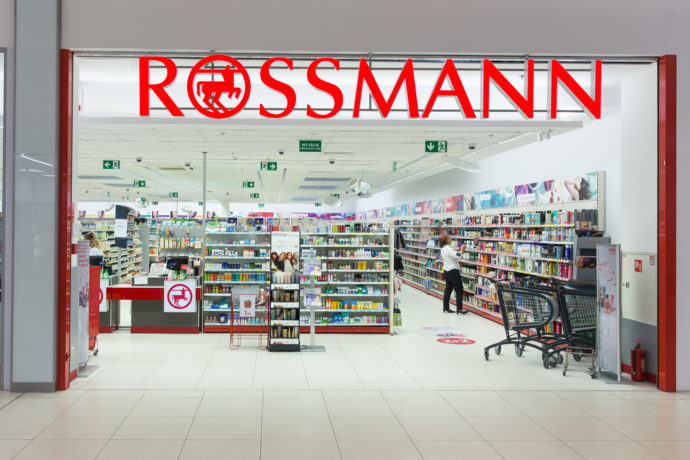

**Table of contents:**

1. [Imports](#imports) <br>
    1.1. [Helper Functions](#helper_functions)<br>
    1.2. [Loading Data](#loading_data)<br>
2. [Data Description](#data_description)<br>
    2.1. [Rename Columns](#rename_columns)<br>
    2.2. [Data Dimensions](#data_dimensions)<br>
    2.3. [Data Types](#data_types)<br>
    2.4. [Check NA](#check_na)<br>
    2.5. [Fillout NA](#fillout_na)<br>
    2.6. [Change Data Types](#change_data_types)<br>
    2.7. [Descriptive Statistical](#descriptive_statistical)<br>
3. [Feature Engineering](#feature_engineering)<br>
    3.1. [Hypothesis Creation](#hypothesis_creation)<br>
    3.2. [Final Hypothesis List](#final_hypothesis_list)<br>
    3.3. [New Features](#new_features)<br>
4. [Data Filtering](#data_filtering)<br>
    4.1. [Rows Filtering](#rows_filtering)<br>
    4.2. [Columns Selection](#columns_selection)<br>
5. [Exploratory Data Analysis](#exploratory_data_analysis)<br>
    5.1. [Univariate Analysis](#univariate_analysis)<br>
    5.2. [Bivariate Analysis](#bivariate_analysis)<br>
    5.3. [Multivariate Analysis](#multivariate_analysis)<br>
6. [Data Preparation](#data_preparation)<br>
    6.1. [Normalization](#normalization)<br>
    6.2. [Rescaling](#rescaling)<br>
    6.3. [Transformation](#transformation)<br>
7. [Feature Selection](#feature_selection)<br>
    7.1. [Split dataframe into training and test dataset](#train_test)<br>
    7.2. [Boruta as Feature Selector](#boruta)<br>
    7.3. [Manual Feature Selection](#manual_feature_selection)<br>
8. [Machine Learning Modelling](#modelling)<br>
    8.1. [Average Model](#average_model)<br>
    8.2. [Linear Regression](#linear_regression)<br>
    8.3. [Lasso](#lasso)<br>
    8.4. [Random Forest Regressor](#random_forest)<br>
    8.5. [XGBoost Regressor](#xgboost)<br>
    8.6. [Compare Model's Performance](#performance)<br>
9. [Hyperparameter Fine Tunning](#hyperparameter)<br>
    9.1. [RandomizedSearchCV](#random_search)<br>
    9.2. [Final Model](#final_model)<br>
    9.3. [Exporting Final Model](#export_final_model)<br>
10. [Error Interpretation](#error_interpretation)<br>
    10.1. [Business Performance](#business_performance)<br>
    10.2. [Total Performance](#total_performance)<br>
    10.3. [Machine Learning Performance](#machine_learning_performance)<br>
11. [Deploy Model to Production](#deploy)<br>
    11.1. [Rossmann Class](#rossmann_class)<br>
    11.2. [API Handler](#api_handler)<br>
    11.3. [API Tester](#api_tester)<br>

# 1. Imports <a id='imports'></a>

In [78]:
import pandas as pd
import inflection
import numpy as np
import datetime
import os
from scipy import stats
import pickle
import math
from boruta import BorutaPy
import requests

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display  import HTML

## 1.1. Helper Functions <a id='imports'></a>

In [79]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', None)
    
    sns.set()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))

def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [80]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\envs\rossmann\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 1.2. Loading Data <a id='loading_data'></a>

In [81]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# 2. Data Description <a id='data_description'></a>

In [82]:
df1 = df_raw.copy()

## 2.1. Rename Columns <a id='rename_columns'></a>

In [83]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 2.2. Data Dimensions<a id='data_dimensions'></a>

In [84]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 2.3. Data Types<a id='data_types'></a>

In [85]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [86]:
# changing date to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4. Check NA<a id='check_na'></a>

In [87]:
df1.isna().sum().sort_values(ascending = False)

promo_interval                  508031
promo2_since_year               508031
promo2_since_week               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
day_of_week                          0
promo2                               0
assortment                           0
store                                0
school_holiday                       0
state_holiday                        0
promo                                0
open                                 0
customers                            0
sales                                0
date                                 0
store_type                           0
dtype: int64

## 2.5. Fillout NA<a id='fillout_na'></a>

* competition_distance

    * Shows distance in meters to nearest competitor store. If a value is null, it should mean that there are no near competitors. Thus, this columns will be filled with 200000, much higher than the maximun competion_distance value in the dataset
    
* competition_open_since_[month/year]

    * Gives the approximate year and month of the time the nearest competitor was opened. NaN values will be replaced with the month and year that was filled in the date column.
    
* promo2_since_[year/week]

    * Describes the year and calendar week when the store started participating in promo2, which is a continuing and consecutive promotion for some stores. NaN values will be replaced with the month and year that was filled in the date column.
    
* promo_interval
    
    * Describes the consecutive intervals promo2 is started, naming months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store. NaN values are replaced with 0 and checked if the store participated in promo2 or not represented by 0 and 1 in a column named is_promo.  

In [88]:
# competition_distance
df1['competition_distance'].fillna(200000, inplace = True)

# competition_open_since_month
df1['competition_open_since_month'].fillna(df1['date'].dt.month, inplace = True)

# competition_open_since_year
df1['competition_open_since_year'].fillna(df1['date'].dt.year, inplace = True)

# promo2_since_week
df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week, inplace = True)

# promo2_since_year
df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)

# promo_interval -> is_promo
month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 
 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [89]:
df1.isna().sum().sort_values(ascending = False)

store                           0
day_of_week                     0
month_map                       0
promo_interval                  0
promo2_since_year               0
promo2_since_week               0
promo2                          0
competition_open_since_year     0
competition_open_since_month    0
competition_distance            0
assortment                      0
store_type                      0
school_holiday                  0
state_holiday                   0
promo                           0
open                            0
customers                       0
sales                           0
date                            0
is_promo                        0
dtype: int64

## 2.6. Change Data Types<a id='change_data_types'></a>

In [90]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype("int64")
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype("int64")

# promo
df1['promo2_since_week'] = df1['promo2_since_week'].astype("int64")
df1['promo2_since_year'] = df1['promo2_since_year'].astype("int64")

## 2.7. Descriptive Statistical<a id='descriptive_statistical'></a>

A quick overview in numerical and categorical attributes.

In [91]:
# separating numeric and categoric features
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes<a id='numerical_attributes'></a>

* Central tendency
    * mean
    * median
* Dispersion
    * std - standard deviation
    * min
    * max
    * range
    * skew
        * skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean
    * kurtosis
        * measure of the "tailedness" of the probability distribution of a real-valued random variable

In [92]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Evaluating "sales" column:

* Min = 0, means that on that day the store was closed.
* Max = 41551
* Range = 451151 - 0
* Mean = It tells us that on average, 5773 sales are made per day.
* Median = Median very close to the average
* Std = Tell us that our sales may vary by +/- 3849, that is, there are days that total sales are (5773 + 3849) and there are days that total sales are (5773 - 3849)
* Skew = Positive and near to 0, slightly concentrated on the left side 
* Kurtosis = Positive value, indicating that data is more concentrated next to the mean

### 2.7.2. Categorical Attributes<a id='categorical_attributes'></a>

Boxplot

* Shows quantiles (25%, 50%, 75%)
* Max value = Q3 + 1.5 * IQ, where IQ = Q3 - Q1
* Min value = Q1 - 1.5 * IQ, where IQ = Q3 - Q1

Every data point above the max value or under the min value represents a outlier.

In [93]:
# get unique attributes from features
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

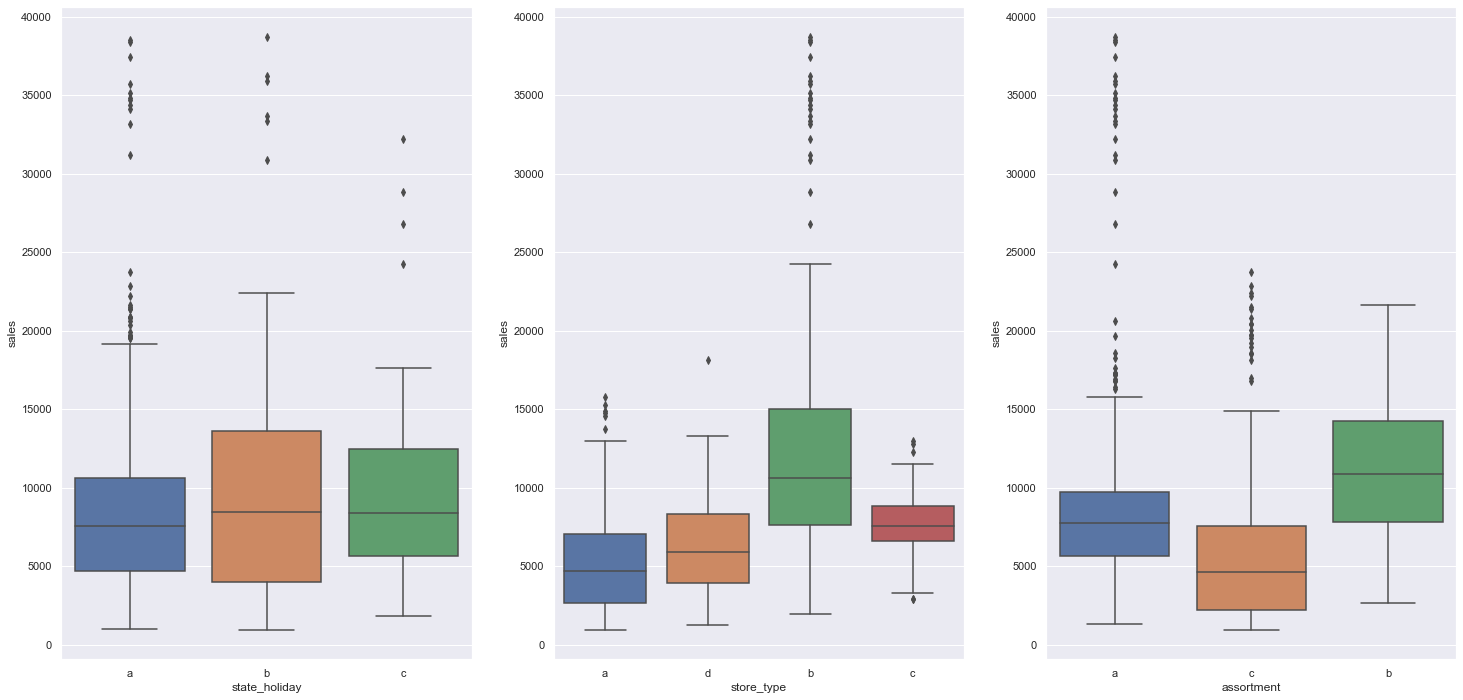

In [94]:
# boxplot
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]

fig, axes = plt.subplots(1, 3)
_ = sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1, ax = axes[0])

_ = plt.subplot(1,3,2)
_ = sns.boxplot(x = 'store_type',y = 'sales', data = aux1, ax = axes[1])

_ = plt.subplot(1,3,3)
_ = sns.boxplot(x = 'assortment', y = 'sales', data = aux1, ax = axes[2])

Some inferences from the data:

* state_holiday \\(\rightarrow\\) Holiday "b" has a median higher than "a" but very similar to "c".
* store_type \\(\rightarrow\\) type of store "b" has a lot more outliers and a larger amount of sales. Store "b" has a very large amount of data around the median. "a" and "d" have a similar dispersion around the median.
* assortment \\(\rightarrow\\) "b" has more sales compared to other types of assortment

# 3. Feature Engineering<a id='feature_engineering'></a>

* What's the phenomenon that we are modelling?
    * Sales
* What's the agent descriptions?
    * Age, Sex, Job

In [95]:
df2 = df1.copy()

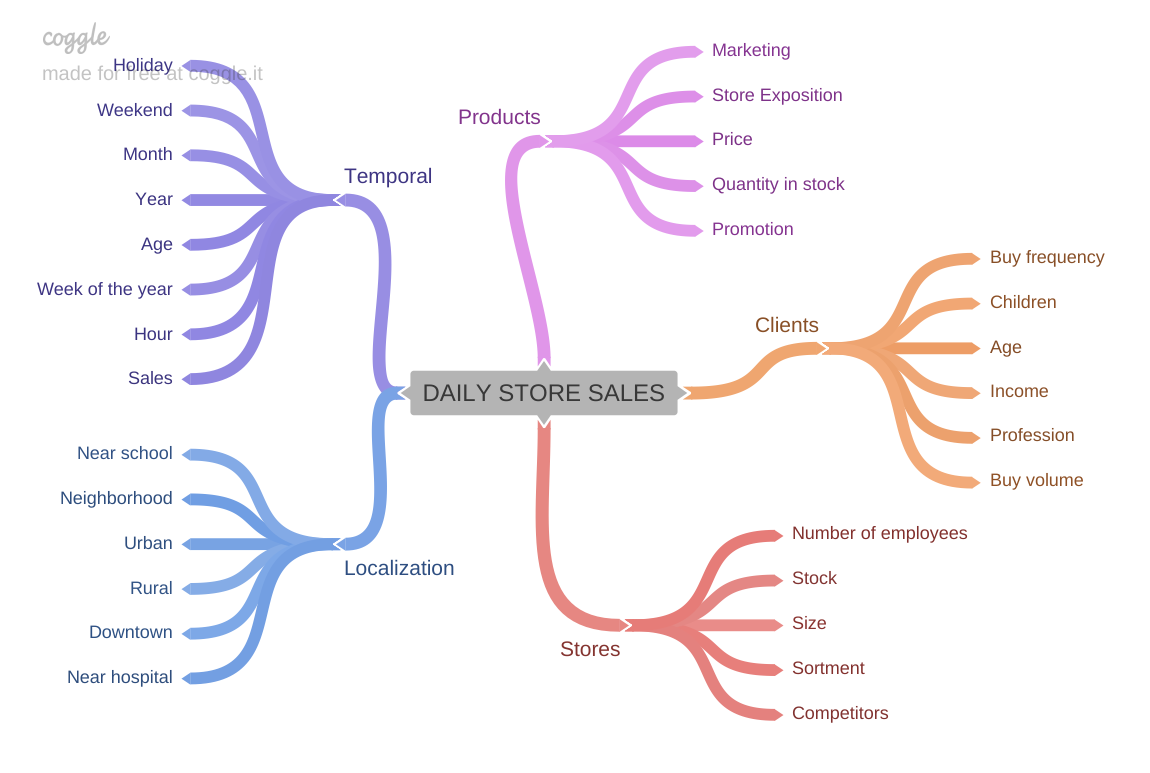

## 3.1. Hypotheses Creation<a id='hypothesis_creation'></a>

### 3.1.1. Store's Hypotheses<a id='stores_hypothesis'></a>

**1.** Stores with a larger workforce should sell more.

**2.** Stores with a larger stock should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less

**6.** Stores with longer competitors should sell more

### 3.1.2. Product's Hypotheses<a id='products_hypothesis'></a>

**1.** Stores that invest more in marketing should sell more.

**2.** Stores that exhibit more product in store windows should sell more.

**3.** Stores that have lower prices should sell more.

**4.** Stores that have more aggressive promotions (bigger discounts), should sell more

**5.** Stores that have prices less for longer products should sell more.

**6.** Stores with more promotion days should sell more

**7.** Stores with more consecutive promotions should sell more.

### 3.1.3. Time's Hypotheses<a id='times_hypothesis'></a>

**1.** Stores opened during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 3.2. Final Hypotheses List<a id='final_hypothesis_list'></a>

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores that have prices less for longer products should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 3.3. New features<a id='new_features'></a>

Aiming to validate the hypotheses, the following features are created:

* year
* month
* day
* week of day
* year week \\(\rightarrow\\) year and week in the format "2019-22"

In [96]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment 
#a = basic, b = extra, c = extended
assortment = {'a' : 'basic', 'b' : 'extra', 'c' : 'extended'}
df2['assortment'] = df2['assortment'].map(assortment)

#state_holiday
#a = public_holiday, b = easter_holiday, c = christmas, 0 = regular_day
state_holiday = {'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday)

# 4. Data Filtering<a id='data_filtering'></a>

The data is commonly filtered due to business restrictions.

In [97]:
df3 = df2.copy()

## 4.1. Rows Filtering <a id='rows_filtering'></a>

Here, the rows where the store is closed or the sales were 0 at that day will be removed from the dataset.

In [98]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 4.2. Columns Selection <a id='columns_selection'></a>

The following columns will be droped:

**1.** Customer: As we will not have the number of customers to predict the future sales, it will be droped. A new model could be created to predict this variable.

**2.** Open: Since all the closed stores were removed, this column can be droped.

**3.** Promo_interval / month_map: From these features, the column "is_promo" was created. Then, they can be droped.

In [99]:
df3.drop(columns = ['customers','open','promo_interval','month_map'], axis = 1, inplace = True)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 5. Exploratory Data Analysis<a id='exploratory_data_analysis'></a>

* Univariate Analysis
    * Min, max, range, distribution
* Bivariate Analysis
    * How the feature impacts the target?
    * Correlation, hypothesis testing
* Multivariate Analysis
    * How the features are related to each other?
    * Correlation

In [100]:
df4 = df3.copy()

## 5.1. Univariate Analysis<a id='univariate_analysis'></a>

### 5.1.1. Response Variable

The sales distribution is shifted to the left, meaning it has positive skewness. It is important to know since many machine learning models work better with normal distributions.

D:\Anaconda\envs\rossmann\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


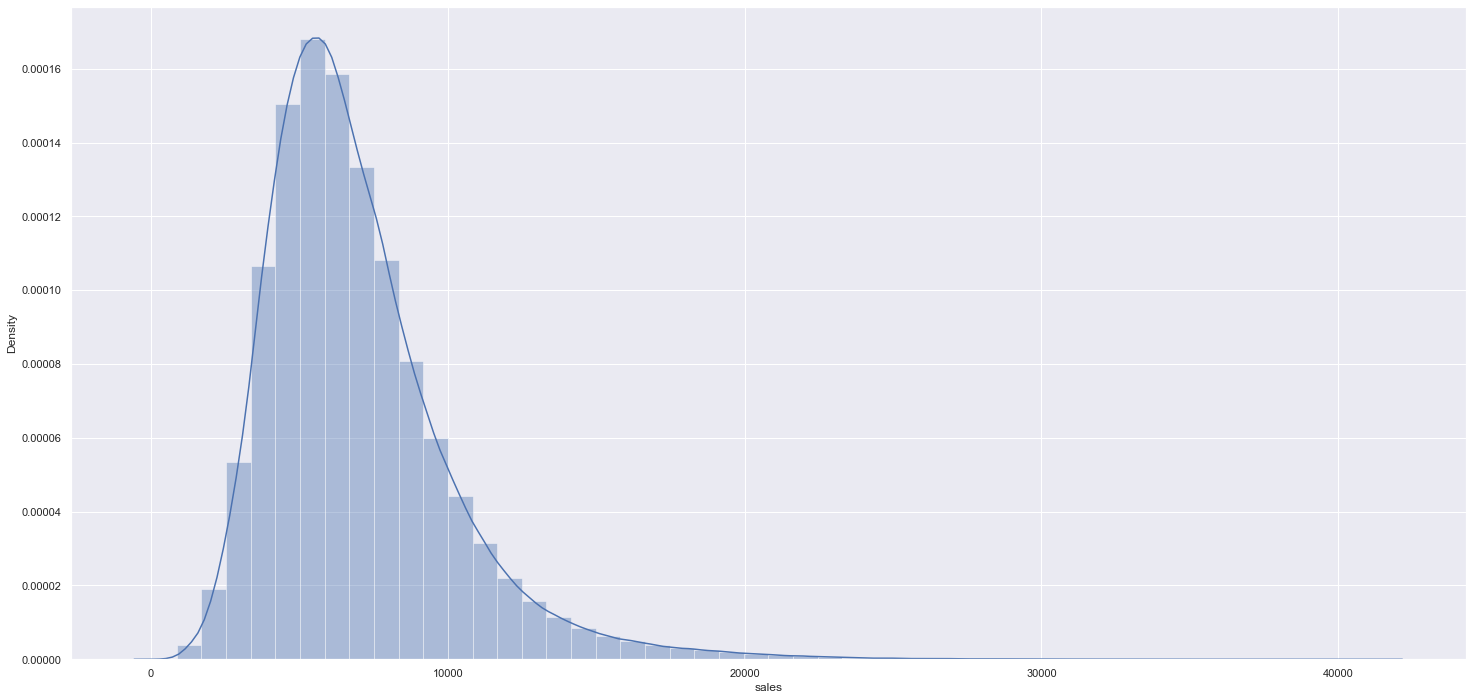

In [101]:
_ = sns.distplot(df4['sales'])

### 5.1.2. Numerical Variable

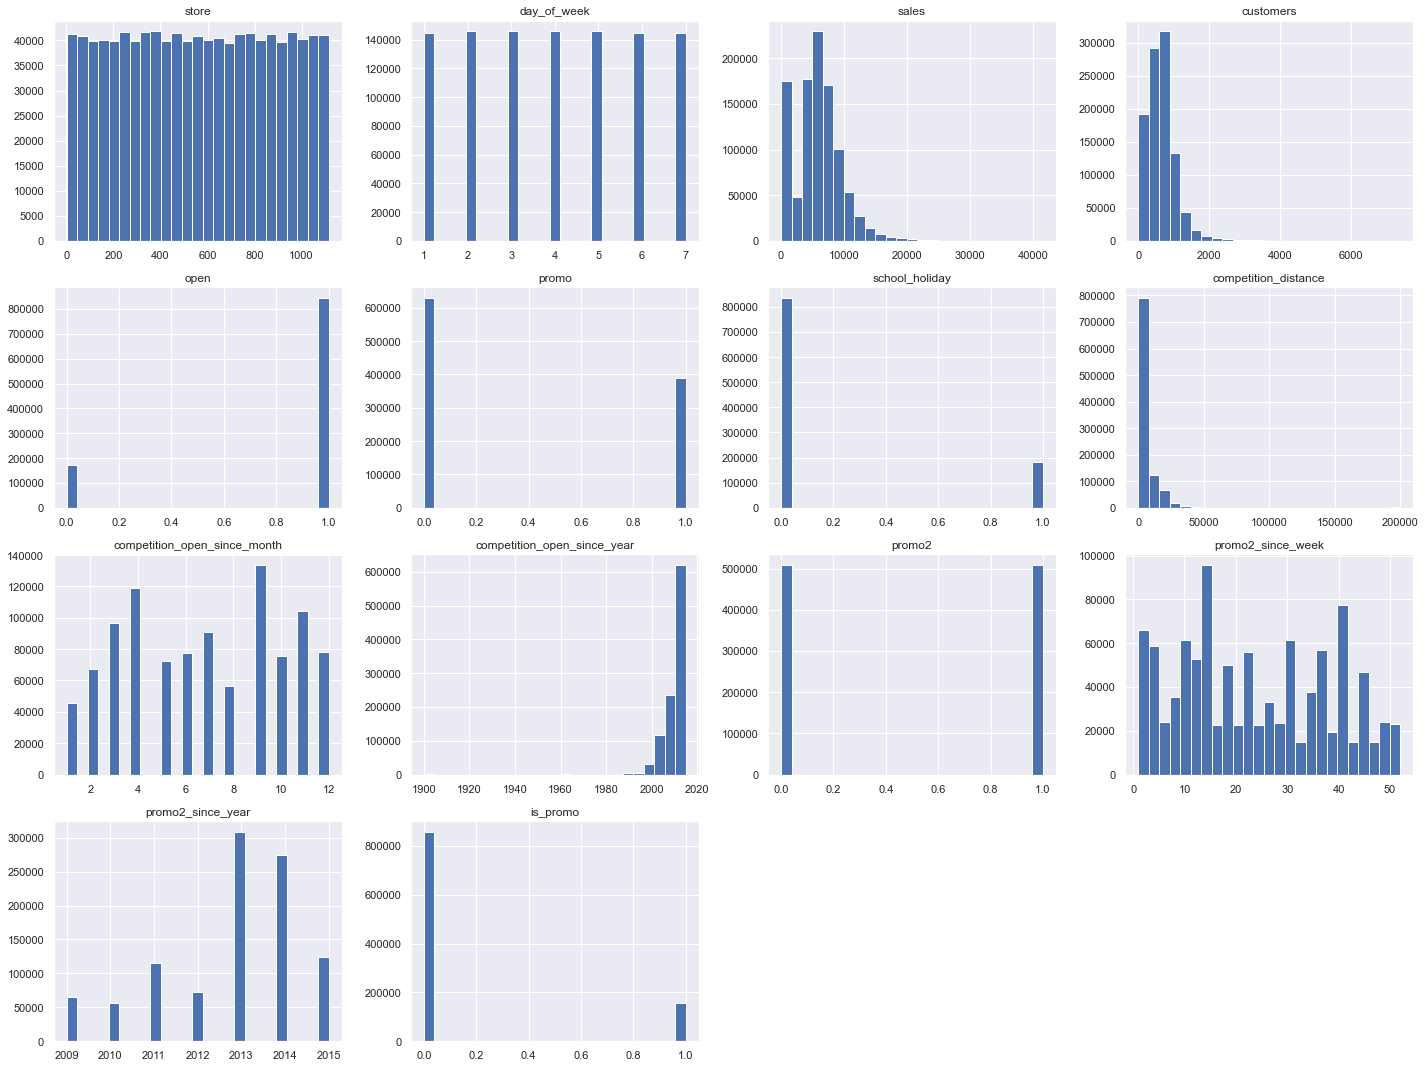

In [102]:
_ = num_attributes.hist(bins = 25, figsize = (20,15))
_ = plt.tight_layout()

From the graphs above, we can get some conclusions:

* **competition_distance** \\(\rightarrow\\) bigger concentrations in smaller intervals. So, there's a lot of close competitors.

* **competition_open_since_month** \\(\rightarrow\\) has an increase until the fourth month and reaches the maximum. From that there is a fall. Therefore, this feature has a certain variation.

* **day_of_week** \\(\rightarrow\\) there is no variation, so, the day of the week will not influence sales. There is no variation.

* **is_promo** \\(\rightarrow\\) there are a lot more sales when there are no promotions. This can be an insight, we will check soon.

* **promo2_since_year** \\(\rightarrow\\) there is a very high peak in 2013, we need to check what happened that year.

### 5.1.3. Categorical Variable

In [103]:
df4.select_dtypes(include = 'object').columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

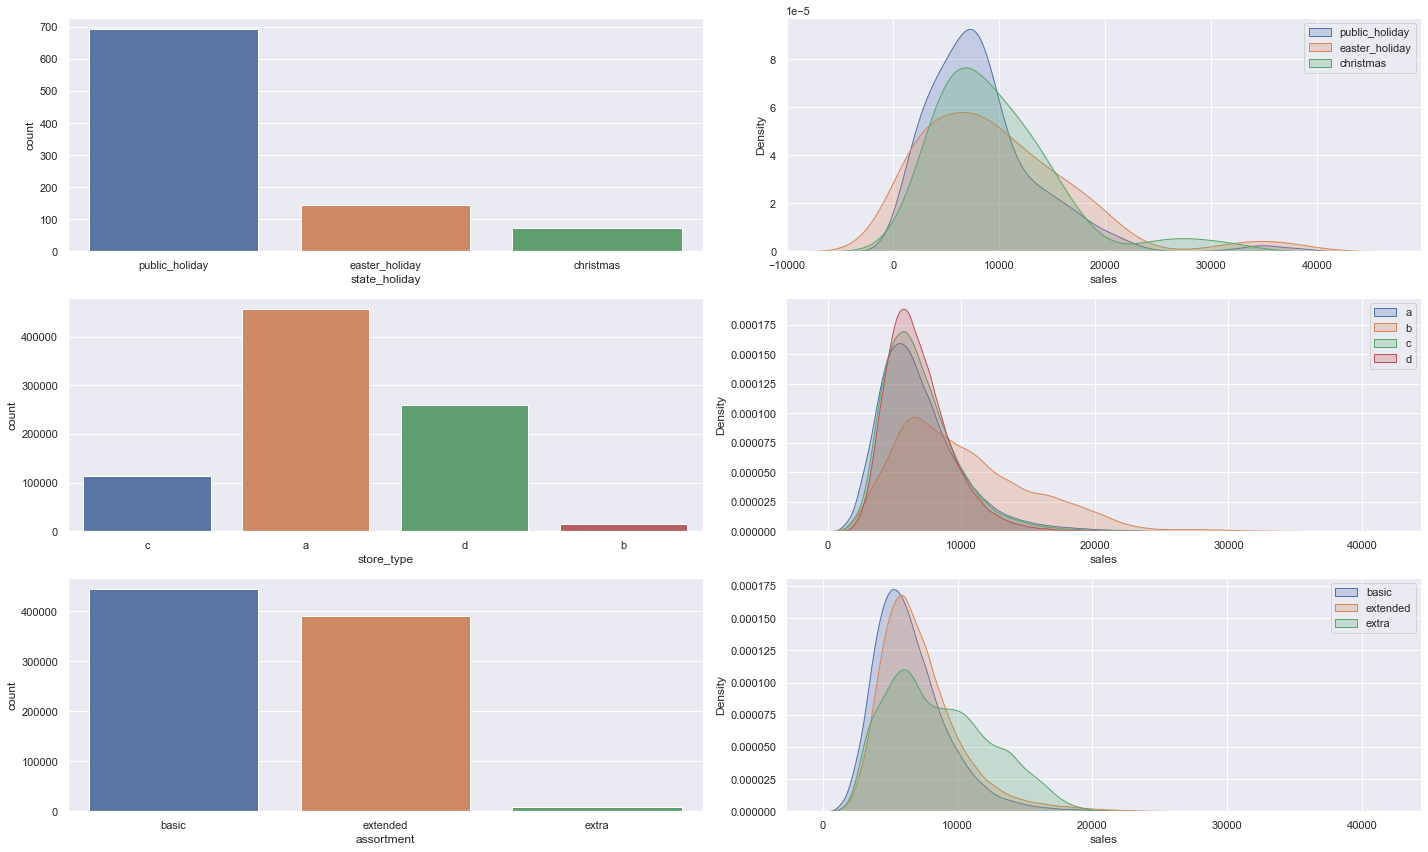

In [104]:
fig, axes = plt.subplots(3,2, figsize  = (20,12))

#state_holiday
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot(x = a['state_holiday'], ax = axes[0][0])

sns.kdeplot(x = df4[df4['state_holiday'] == 'public_holiday']['sales'],label = 'public_holiday',shade = True, ax = axes[0][1])
sns.kdeplot(x = df4[df4['state_holiday'] == 'easter_holiday']['sales'],label = 'easter_holiday',shade = True, ax = axes[0][1])
sns.kdeplot(x = df4[df4['state_holiday'] == 'christmas']['sales'],label = 'christmas',shade = True, ax = axes[0][1])

#store_type
sns.countplot(x = df4['store_type'], ax = axes[1][0])

sns.kdeplot(x = df4[df4['store_type'] == 'a']['sales'],label = 'a',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'b']['sales'],label = 'b',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'c']['sales'],label = 'c',shade = True, ax = axes[1][1])
sns.kdeplot(x = df4[df4['store_type'] == 'd']['sales'],label = 'd',shade = True, ax = axes[1][1])

#assortment
sns.countplot(x = df4['assortment'], ax = axes[2][0])

sns.kdeplot(x = df4[df4['assortment'] == 'basic']['sales'], label  = 'basic', shade = True, ax = axes[2][1])
sns.kdeplot(x = df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True, ax = axes[2][1])
sns.kdeplot(x = df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True, ax = axes[2][1])

# final configurations to the plots
axes[0][1].legend()
axes[1][1].legend()
axes[2][1].legend()
plt.tight_layout()
plt.show()

From all the plots above, we can get some conclusions:

* **state_holiday** \\(\rightarrow\\) there are a much larger amount of sales on public holidays, but at Christmas, which has a smaller amount of sales than easter_holiday, it has a higher peak.

* **store_type** \\(\rightarrow\\) The store_type "a" that sells more, does not have such a peak compared to the others.

* **assortment** \\(\rightarrow\\) stores with the "extra" type assortment sell less, but have a higher distribution. So, there are stores that sell more with the "extra" assortment and stores that sell less.

## 5.2. Bivariate Analysis<a id='bivariate_analysis'></a>

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

### H1. Stores with a larger assortment should sell more.¶

**False**. Stores with a larger assortment sell less.

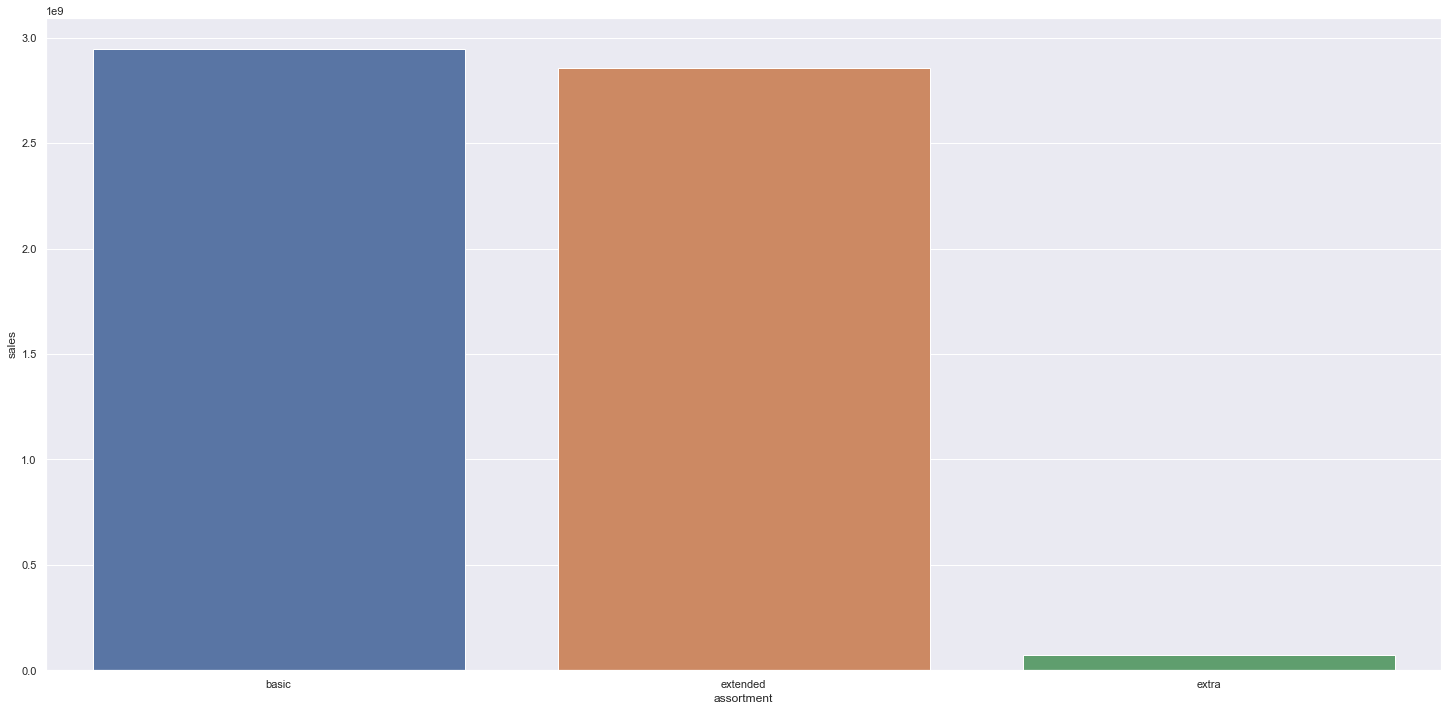

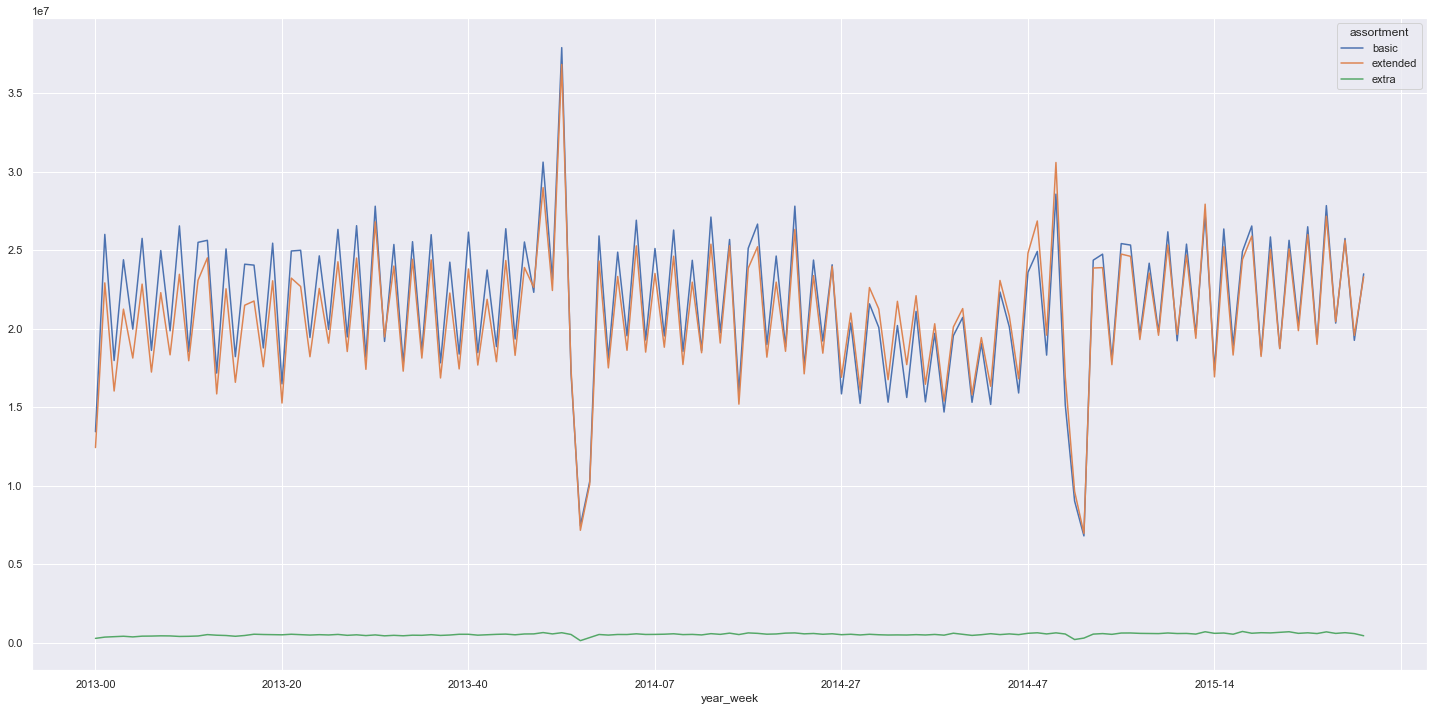

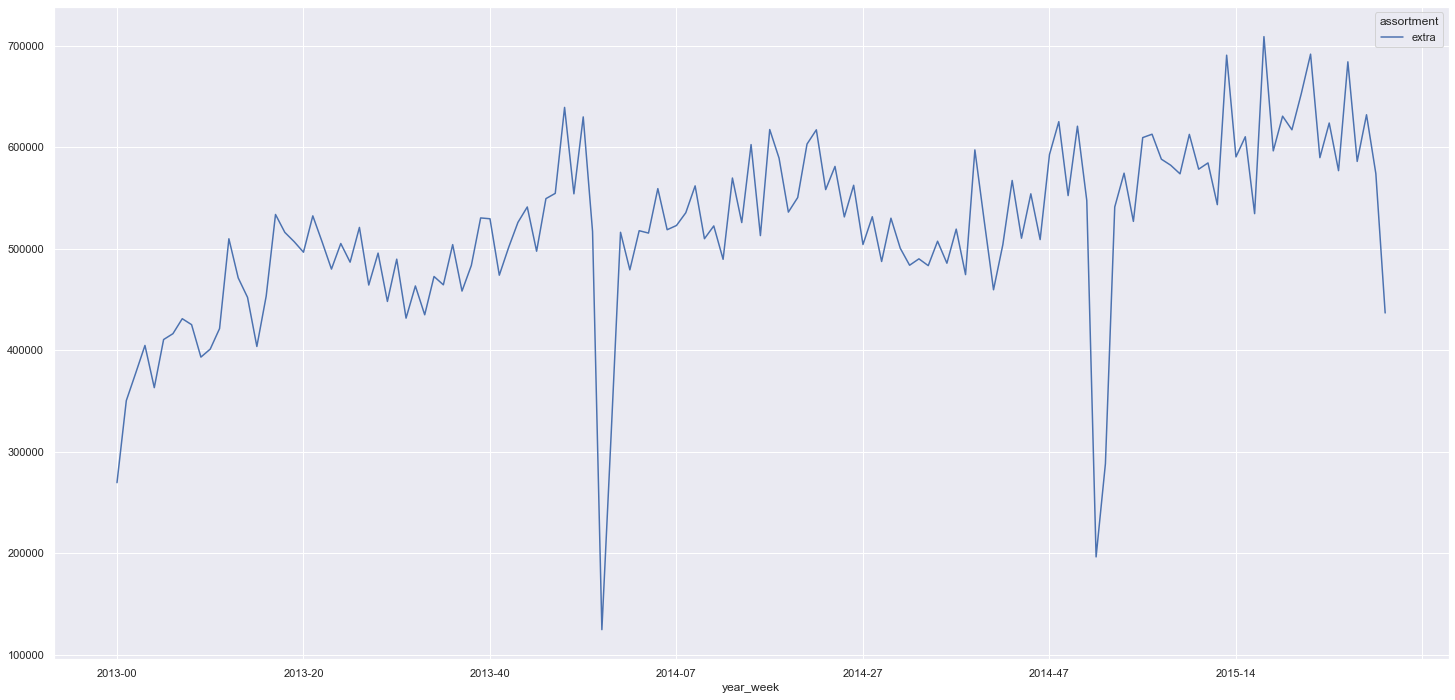

In [105]:
# barplot to check each assortment class count
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

# check by year_week each assortment sales
aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
aux3.plot();

# check extra assortment sales
aux4 = aux2[aux2['assortment'] == 'extra']
aux4 = aux4.pivot(index = 'year_week',columns = 'assortment', values = 'sales')
aux4.plot();

### H2. Stores with closer competitors sell less

**False**. Stores with closer competitors sell more.

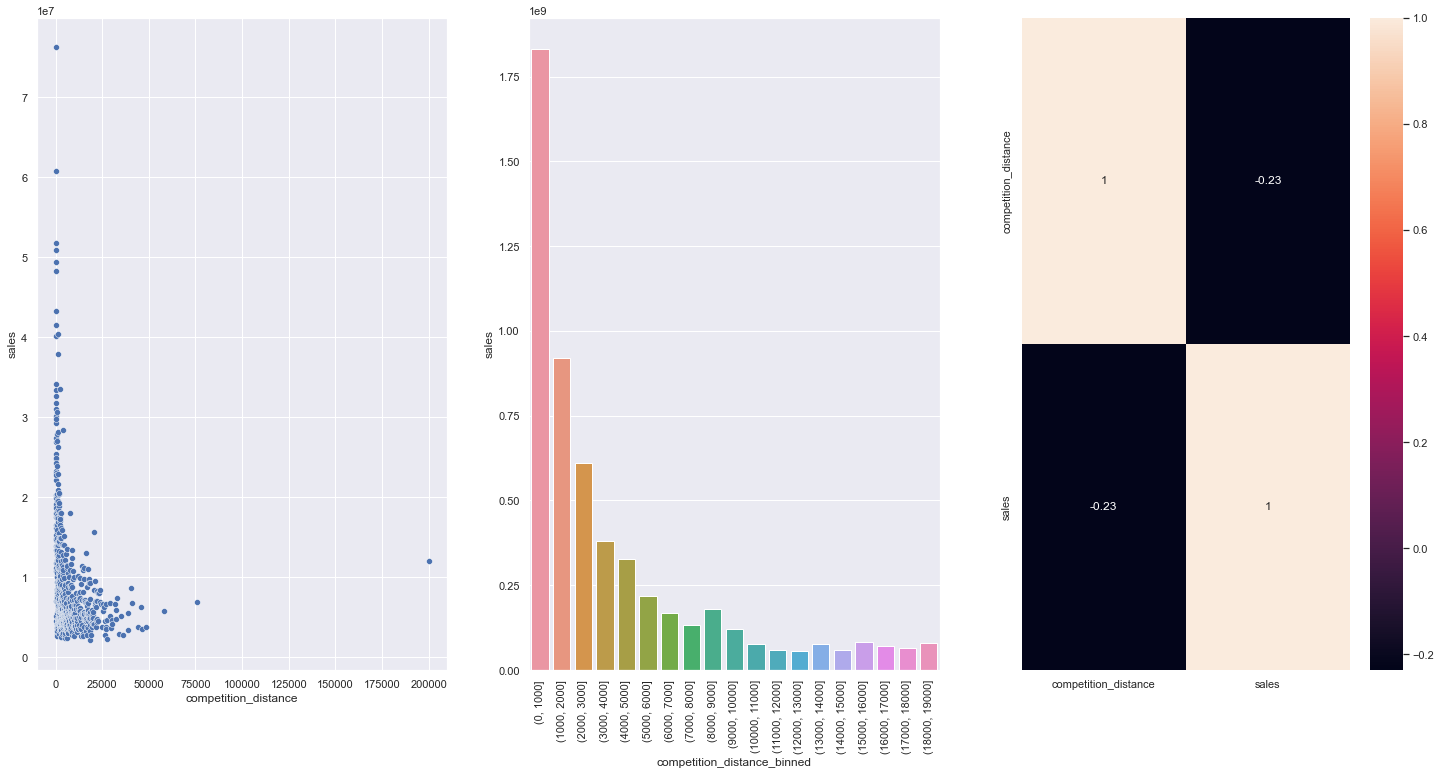

In [106]:
# scatter plot sales x competition distance
plt.subplot(1,3,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

# barplot with bins
plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90)
    
# correlation heatmap
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3. Stores with long time competitors should sell more.

**False**. Stores with long time competitors sell less.

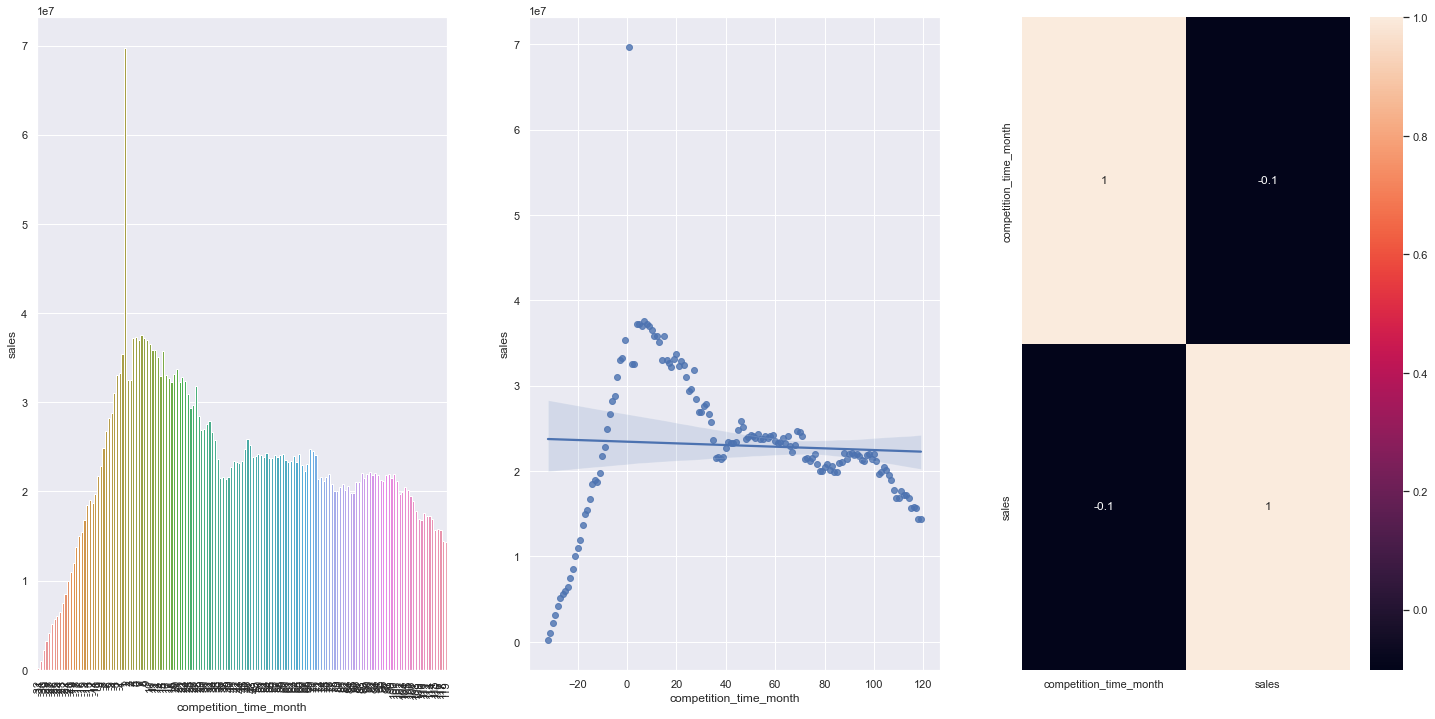

In [107]:
# barplot for sales in competition_time_month
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

# scatter for sales in competition_time_month
plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

# correlation sales - competition_time_month
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H4. Stores with active promotions for longer should sell more.¶

**False**. Stores with active promotions sell less after a certain duration.

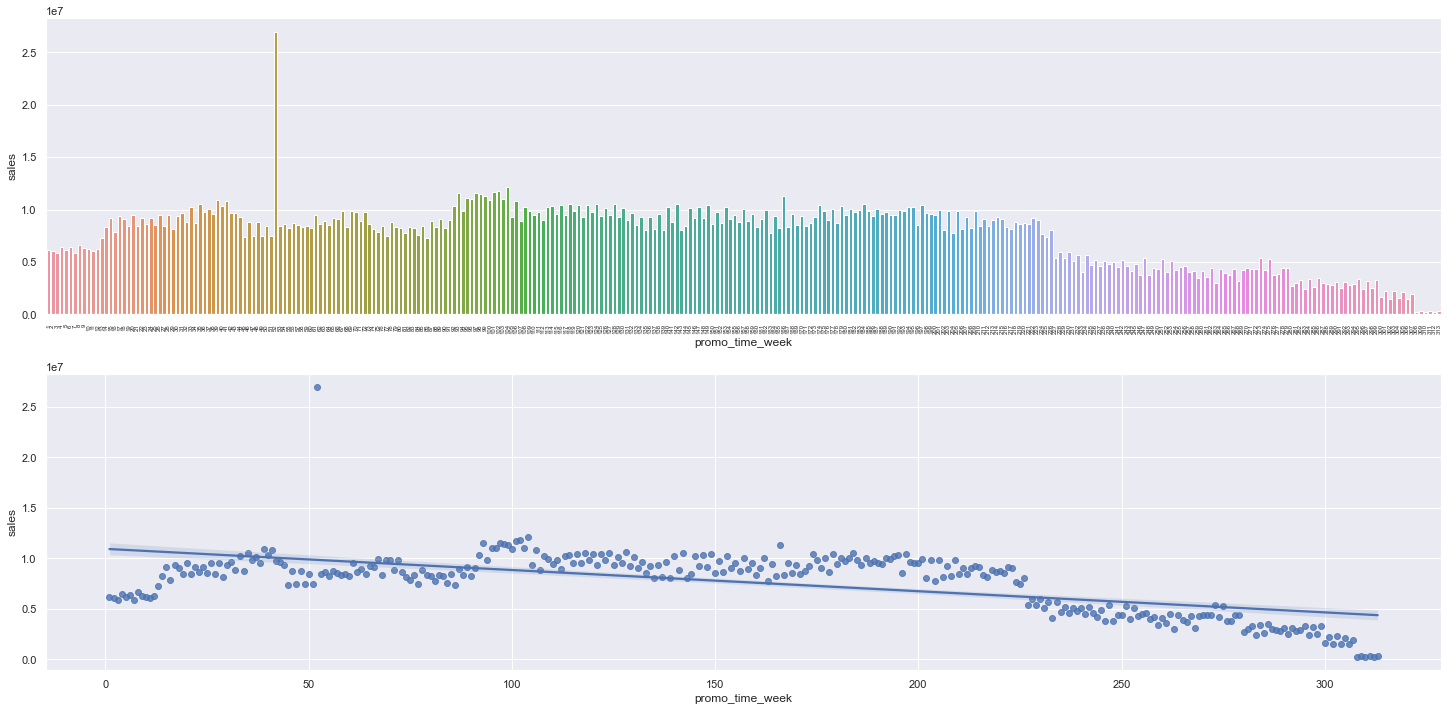

In [108]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

# extended promo period
plt.subplot(2,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] # extended period
sns.barplot(x = 'promo_time_week',y = 'sales', data = aux2);
plt.xticks(rotation = 90, fontsize = 6);

plt.subplot(2,1,2)
sns.regplot(x = 'promo_time_week',y = 'sales', data = aux2);

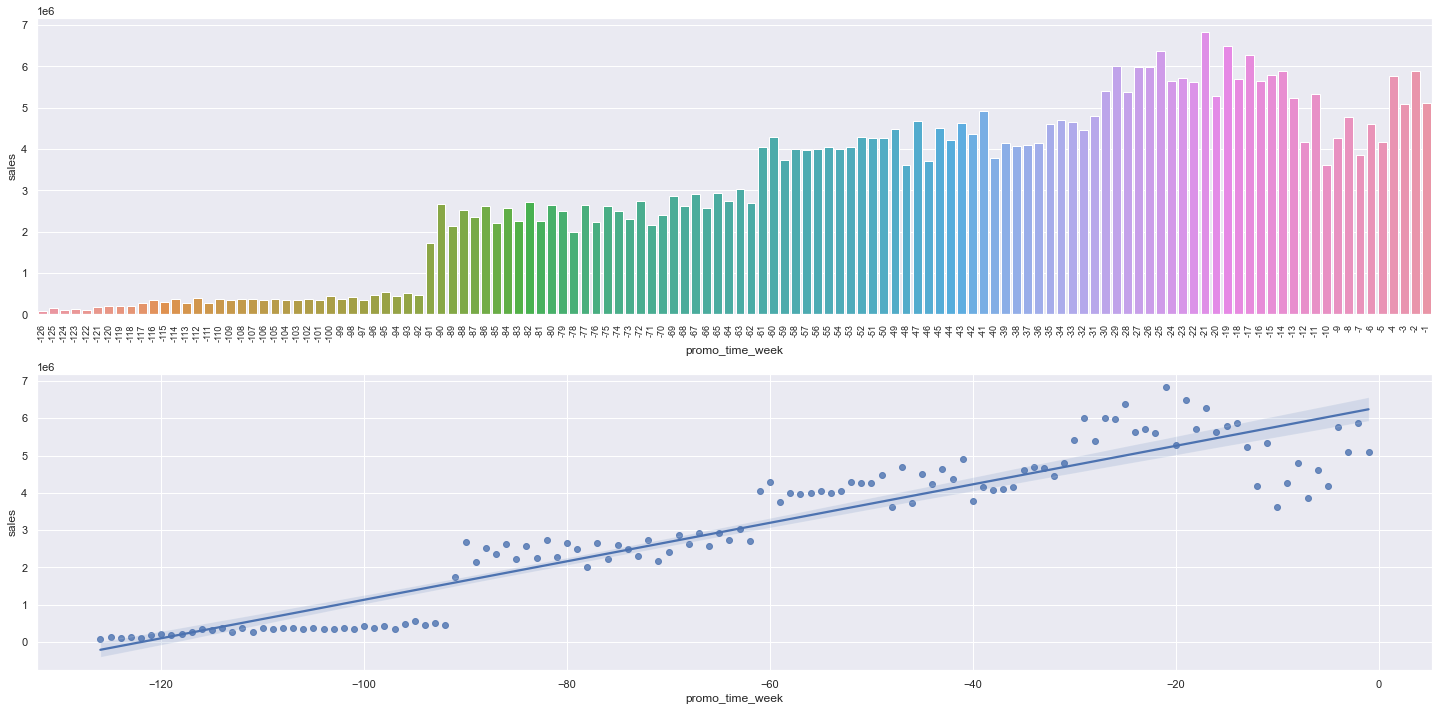

In [109]:
# regular promo period
plt.subplot(2,1,1)
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot(x = 'promo_time_week',y = 'sales', data = aux3);
plt.xticks(rotation = 90, fontsize = 9);

plt.subplot(2,1,2)
sns.regplot(x = 'promo_time_week',y = 'sales', data = aux3);

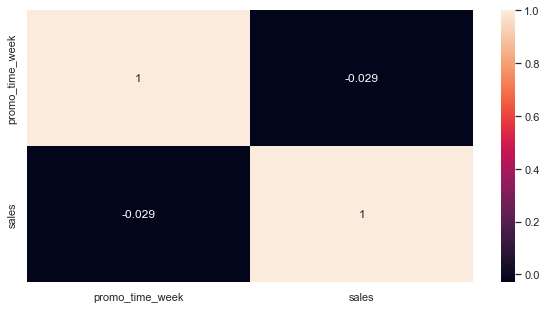

In [110]:
# correlation sales - promo_time_week
fig, ax = plt.subplots(figsize = (10,5))
sns.heatmap(aux1.corr(method = 'pearson'), annot = True, ax = ax);

###  <s> H5. Stores with more promotion days should sell more. <s/>

### H6. Stores with more consecutive promotions should sell more.

**False**. Stores with more consecutive promotions sell less.

In [111]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


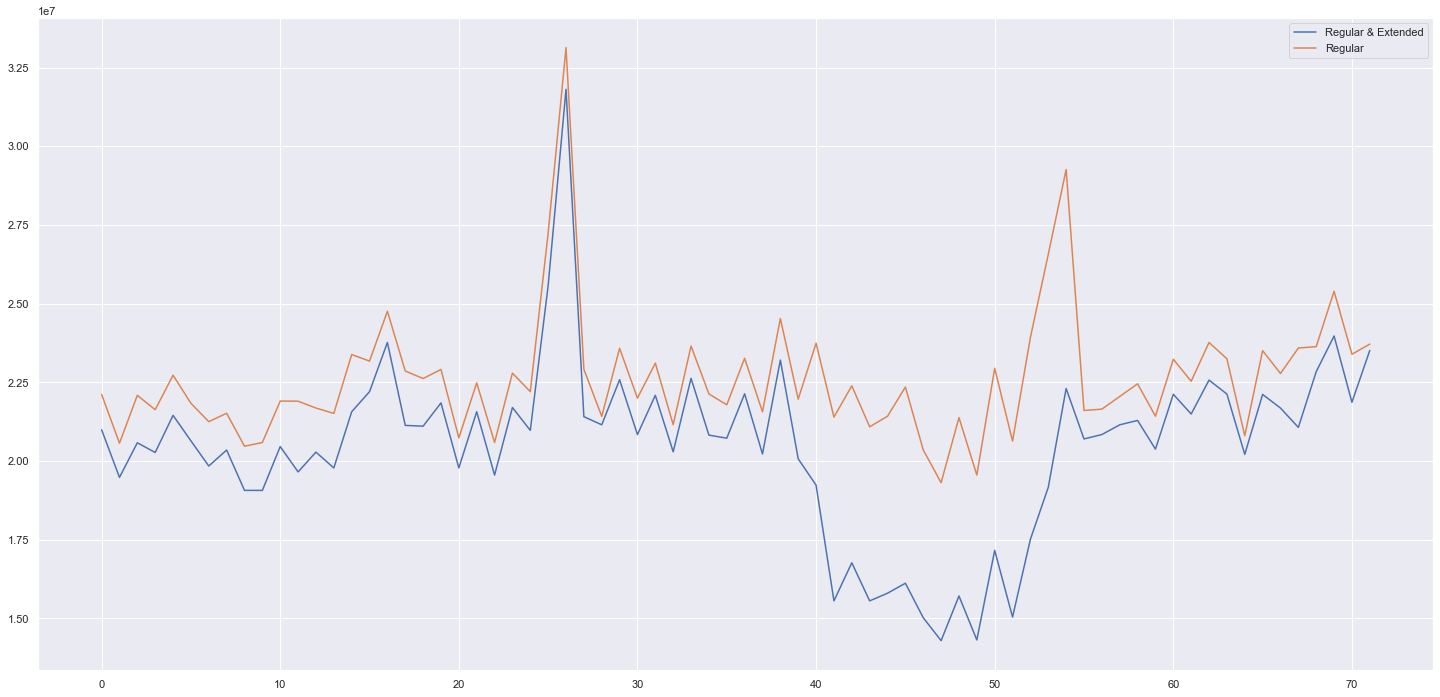

In [112]:
# regular and extended promo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

# regular promo
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax);

ax.legend(labels = ['Regular & Extended', 'Regular']);

### H7. Stores that were opened during the Christmas holiday should sell more.

**False**. Stores open during the Christmas holiday sell less.

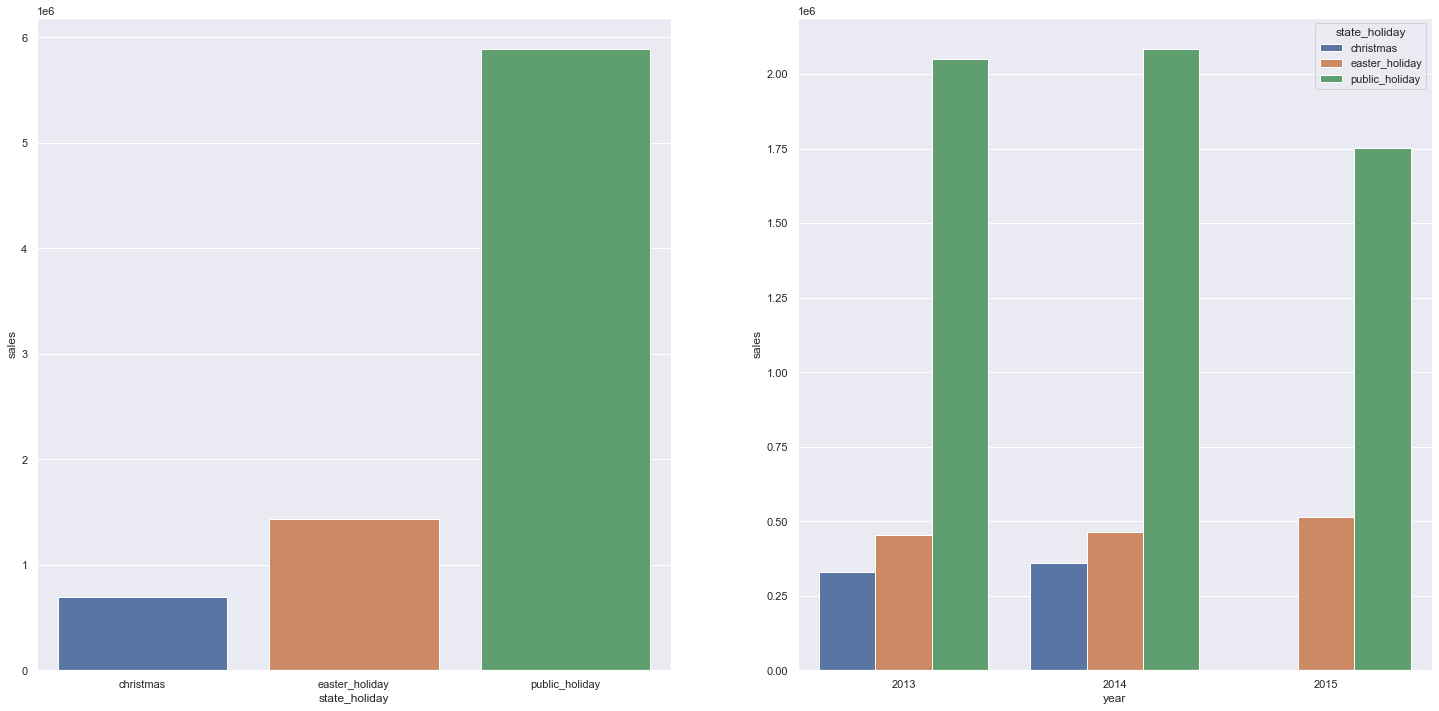

In [113]:
aux = df4[df4['state_holiday'] != 'regular_day']

# sales per holiday
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

# sales per holiday, year
plt.subplot(1, 2, 2)
aux1 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux1);

###  H8. Stores should sell more over the years.

**False**. Stores sell less over the years.

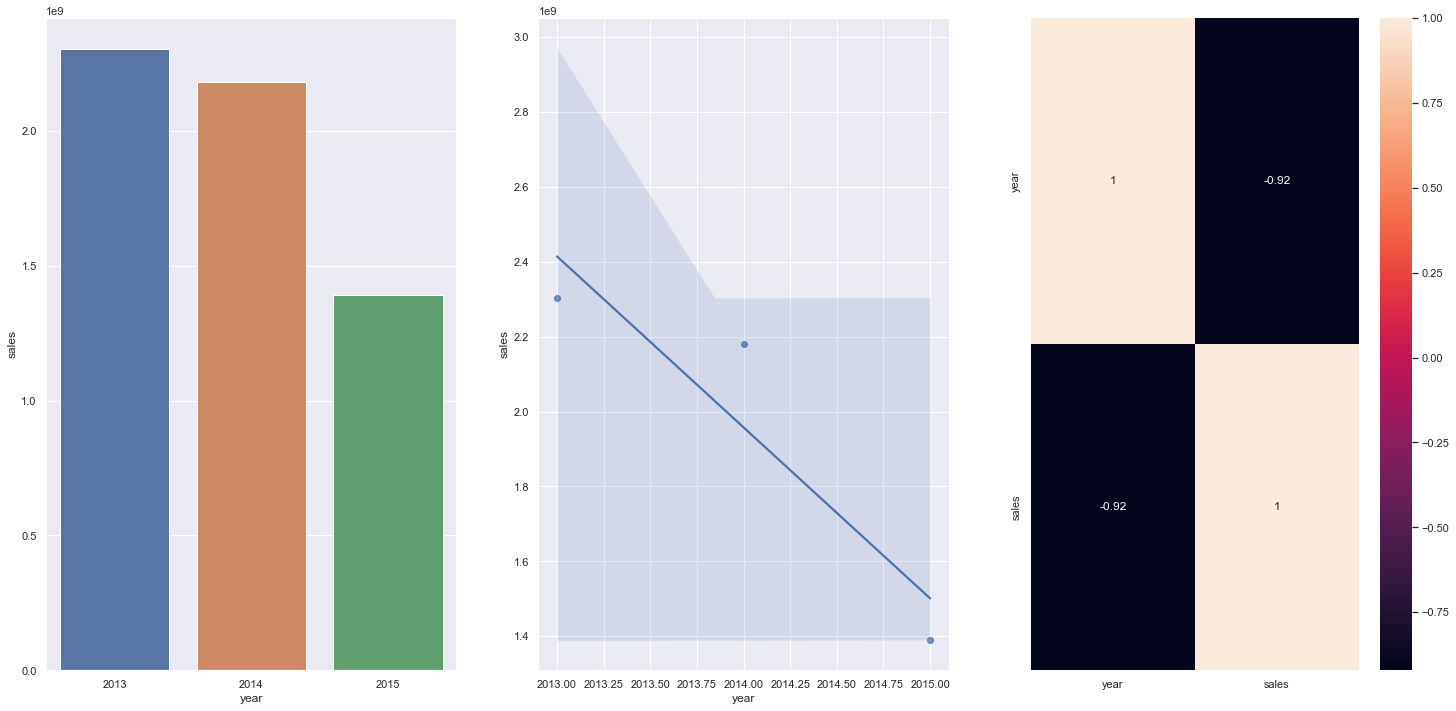

In [114]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

# bar plot sales per year
plt.subplot(1,3,1)
sns.barplot(x = 'year',y = 'sales', data = aux1);

# scatter plot sales per year
plt.subplot(1,3,2)
sns.regplot(x = 'year',y = 'sales', data = aux1);

# correlation year - sales
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H9. Stores should sell more in the second half of the year.

**False**. Stores sell less in the second half of the year.

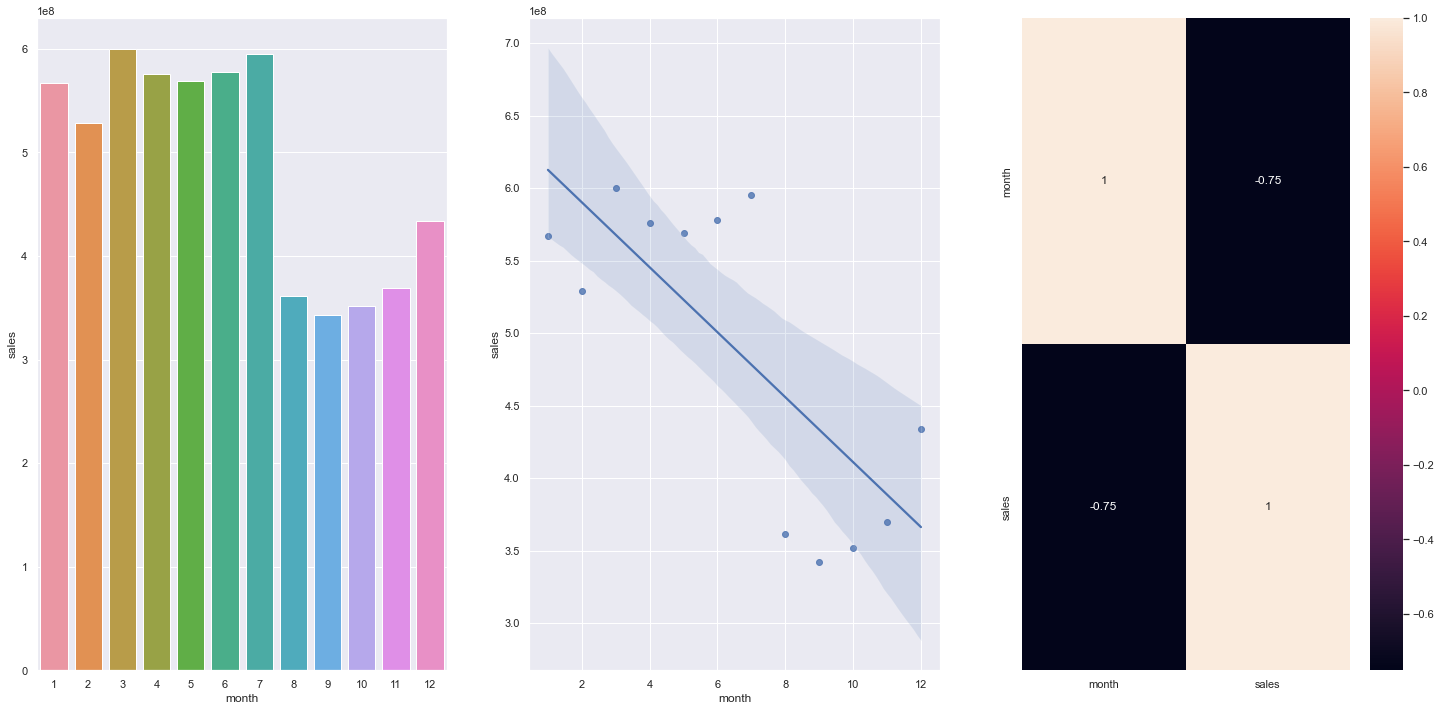

In [115]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

# bar plot sales per month
plt.subplot(1,3,1)
sns.barplot(x = 'month',y = 'sales', data = aux1);

# scatter plot sales per month
plt.subplot(1,3,2)
sns.regplot(x = 'month',y = 'sales', data = aux1);

# correlation month - sales
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H10. Stores should sell more after the 10th of each month.

**True**. Stores sell more after the 10th of each month.

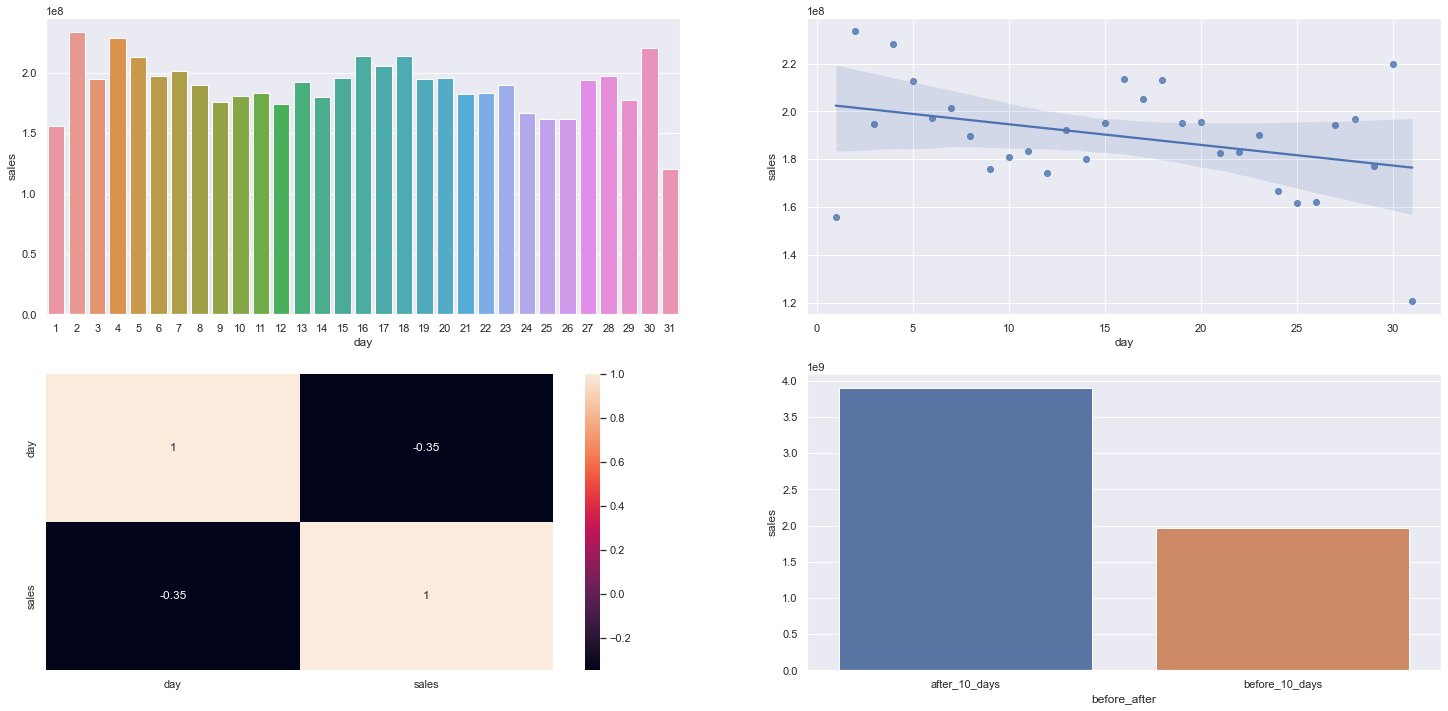

In [116]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

# bar plot sales per day
plt.subplot(2,2,1)
sns.barplot(x = 'day',y = 'sales', data = aux1);

# scatter plot sales per day
plt.subplot(2,2,2)
sns.regplot(x = 'day',y = 'sales', data = aux1);

# correlation day - sales
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

# bar plot sales before the 10th and after the 10th
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

### H11. Stores should sell less on weekends.

**True**. Stores sell less on weekends.

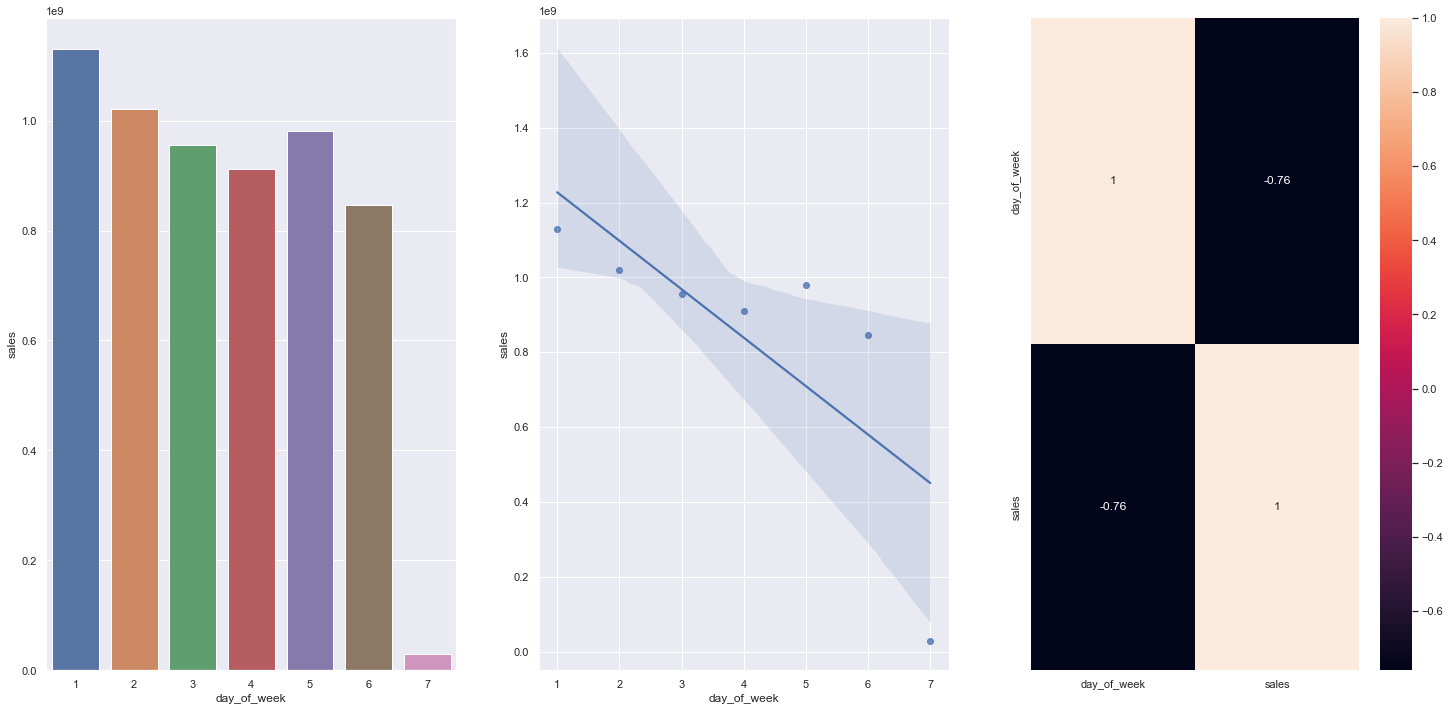

In [117]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

# bar plot sales per day of week
plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week',y = 'sales', data = aux1);

# scatter plot sales per day of week
plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week',y = 'sales', data = aux1);

# correlation sales - day of week
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H12. Stores should sell less during school holidays.

**True**. Stores sell less during school holidays except in July and August.

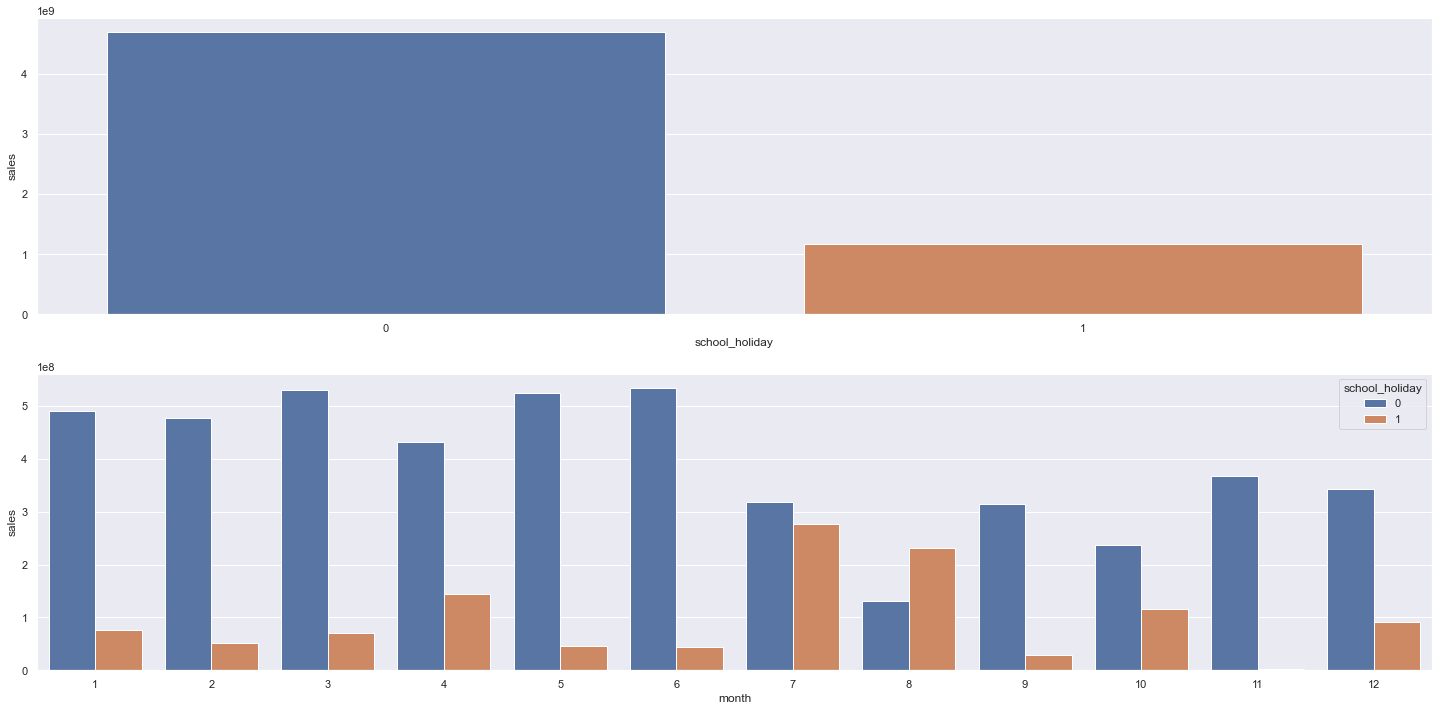

In [118]:
# bar plot sales per school_holiday
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday',y = 'sales', data = aux1);

# bar plot sales per school_holiday, month
plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month',y = 'sales',hue = 'school_holiday', data = aux2);

### 5.2.1. Hypotheses Summary

In [119]:
tab = [['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']]

pd.DataFrame(tab, columns = ['Hypotheses', 'Conclusion', 'Relevance'])

,Hypotheses,Conclusion,Relevance
0,H1,False,Low
1,H2,False,Medium
2,H3,False,Medium
3,H4,False,Low
4,H5,-,-
5,H6,False,Low
6,H7,False,Medium
7,H8,False,High
8,H9,False,High
9,H10,True,High


## 5.3. Multivariate Analysis<a id='multivariate_analysis'></a>

This stage will be divided into two sections:

* Numeric attributes
* Categorical attributes

To check the correlation between numerical variables, we will use the **Pearson** method and for categorical variables, **Cramer's V** method.

### 5.3.1. Numerical Attributes

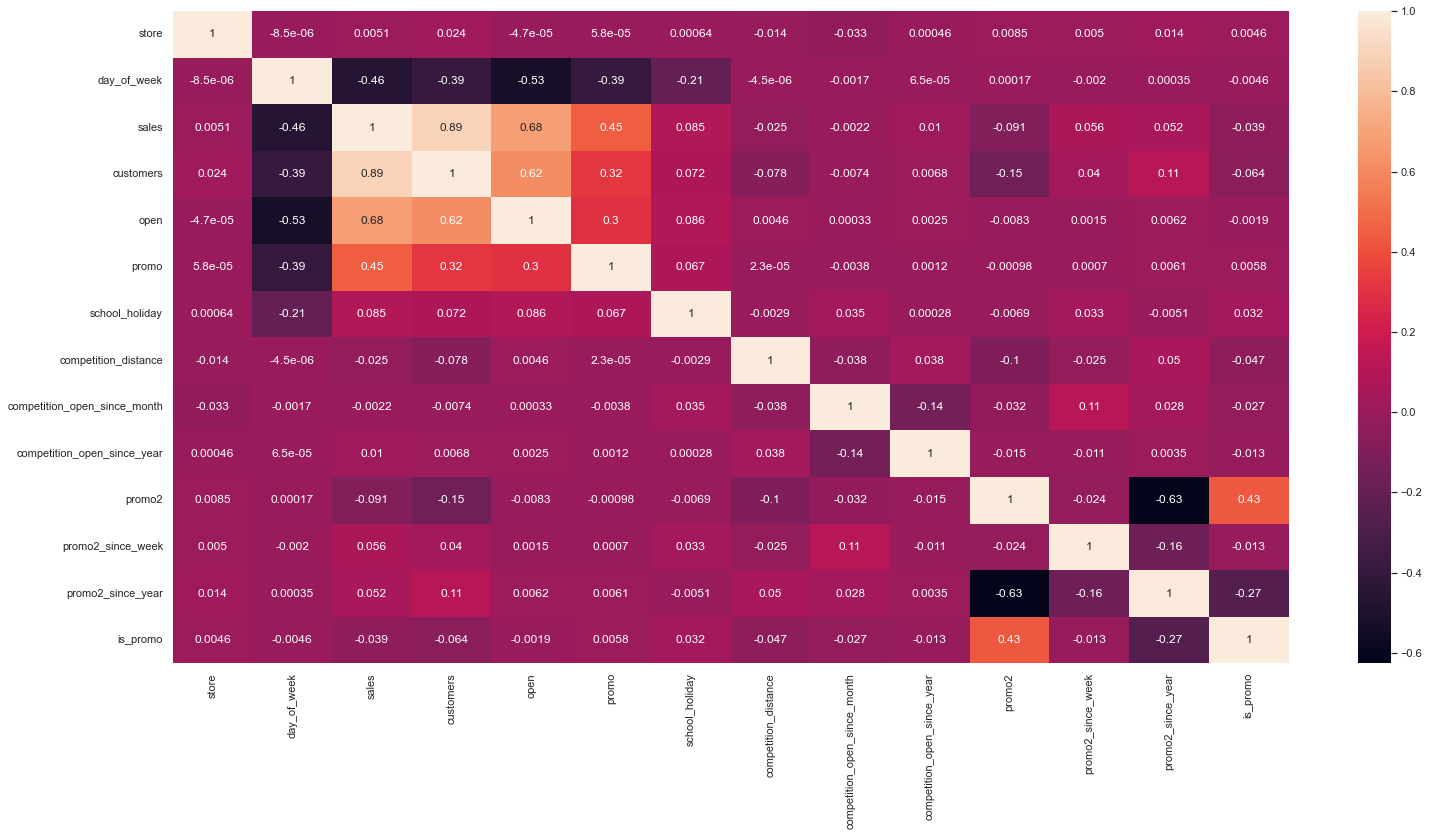

In [120]:
#separating numerical variables and building the heat map
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

The variables that have some dependence on the response variable are: "day_of_week", "open" and "promo". We also have the variable "customers", but we will not have this information when predicting sales, thus, it will be removed.

### 5.3.2. Categorical Attributes

In statistics, Cramer's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). Unlike Pearson's coefficient that goes from -1 to 1, Cramer's V goes from 0 to 1. In other words, there is no negative correlation in categorical variables. We can create a function to apply to all other columns.

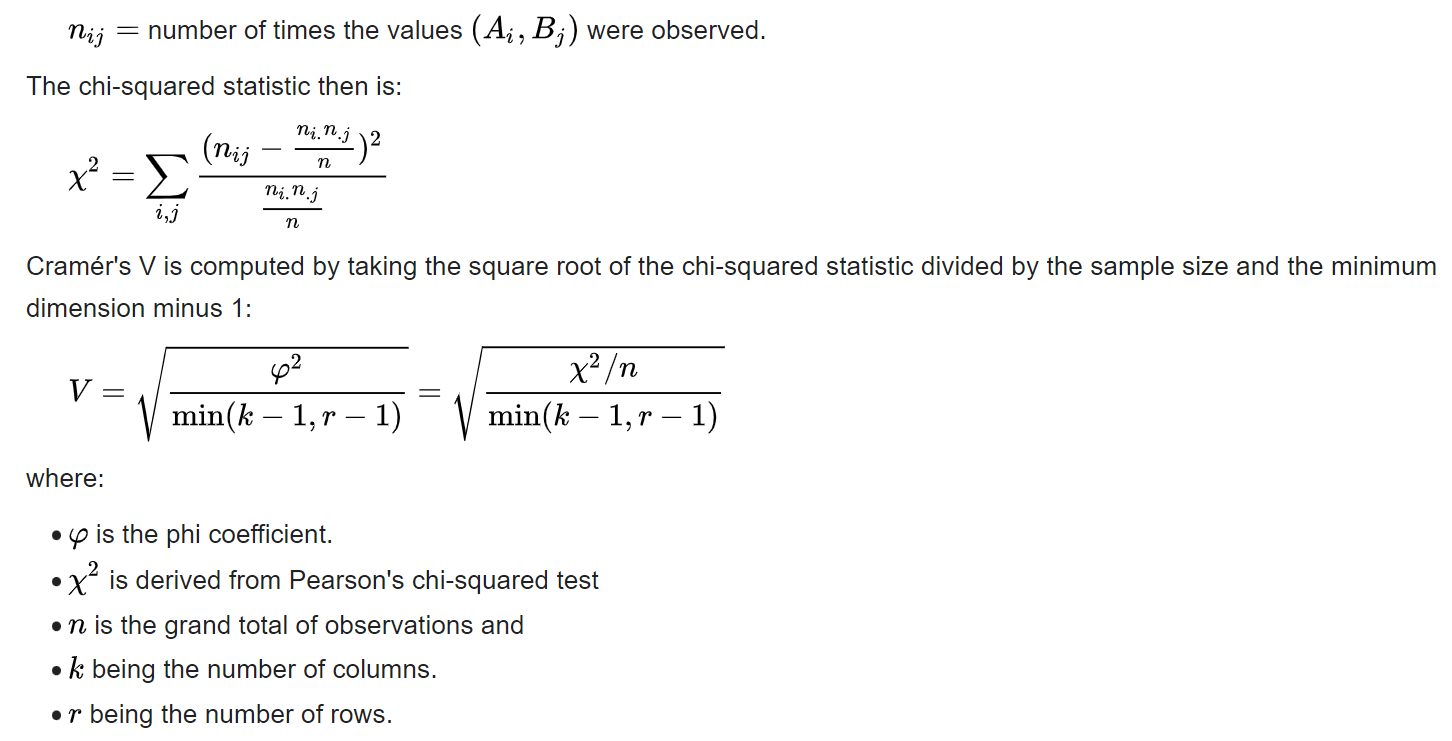

It is necessary to remember that we will need to modify our function a little, because Cramer's V has a very high bias and it may overestimate our analysis, being necessary to carry out the correction. 

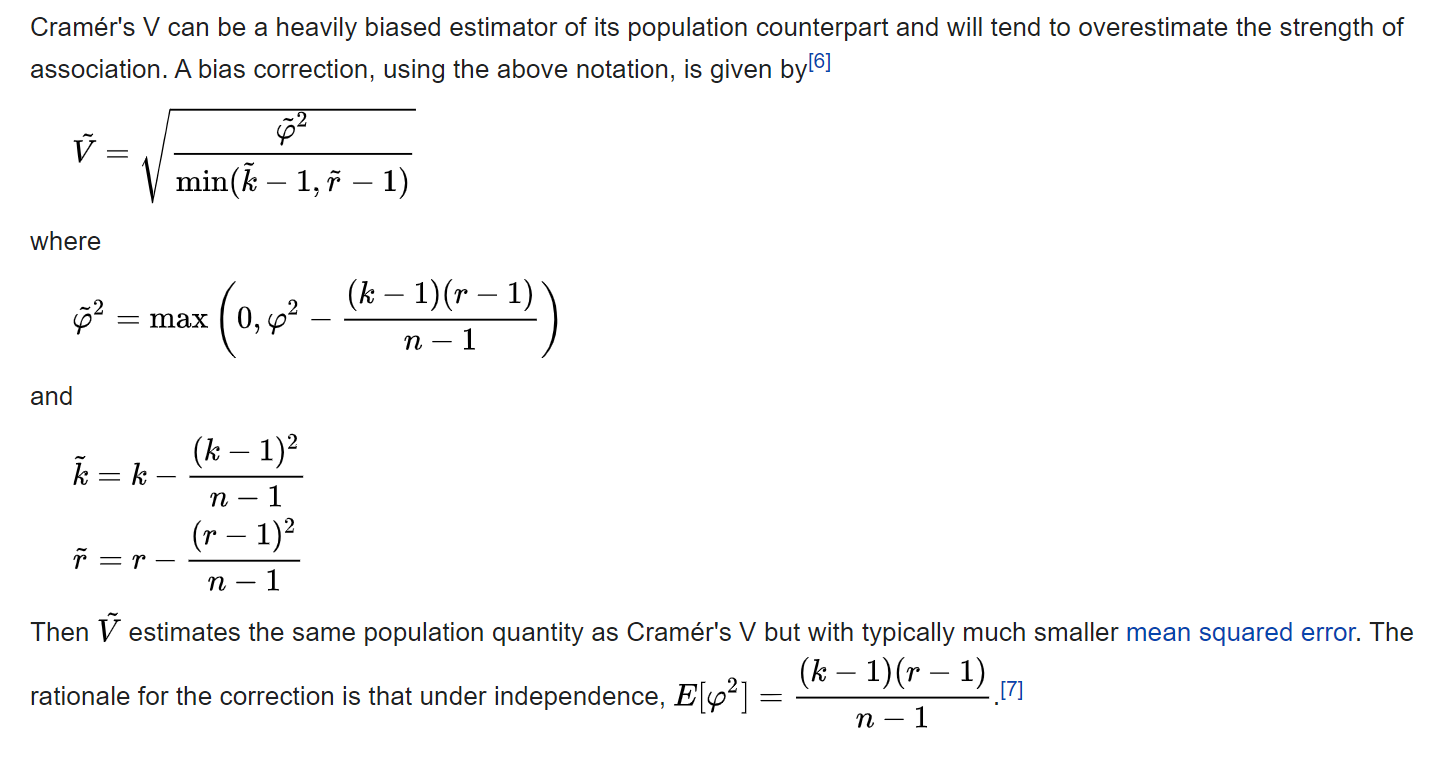

In [121]:
#only categorical data
a = df4.select_dtypes(include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


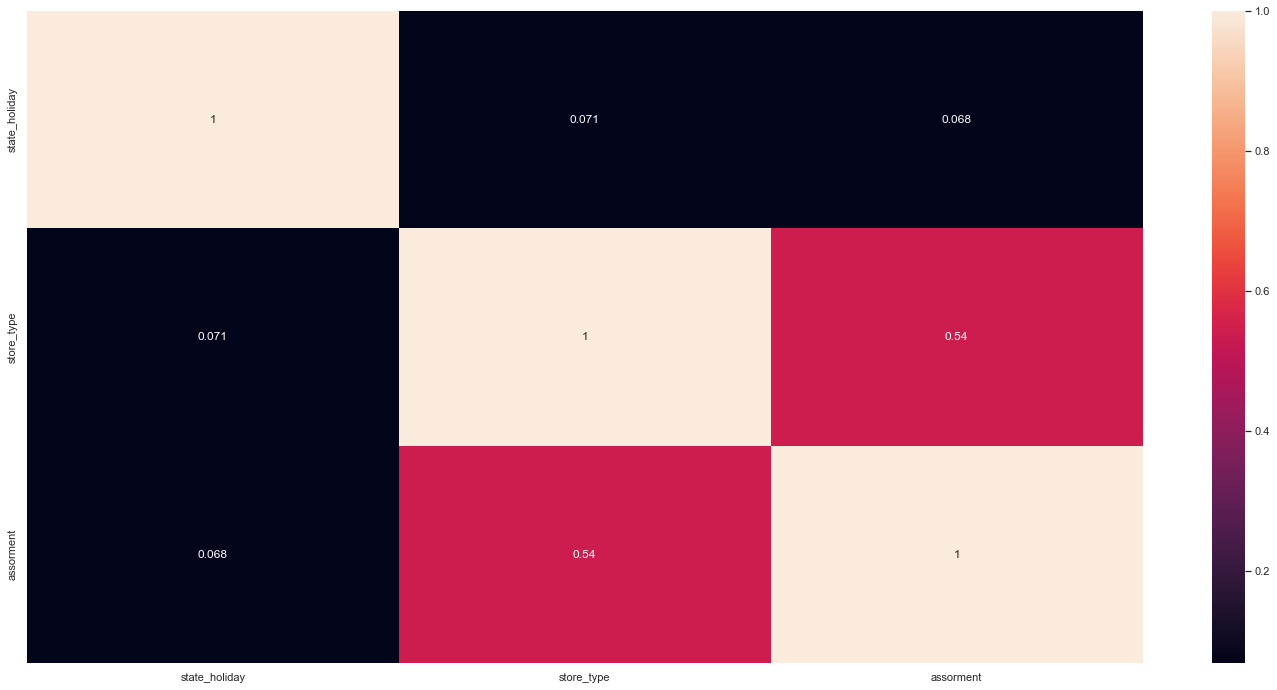

In [122]:
#calculate cramer v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assorment': [a7,a8,a9]
             })

#final dataset
d = d.set_index(d.columns)
sns.heatmap(d , annot = True);

# 6. Data Preparation<a id='data_preparation'></a>

Data preparation types:

**1. Normalization**: rescale data center to 0 with standart deviation equals 1.

**2. Rescaling**: rescale data to interval [0,1].

**3. Transformation**: categorical features to numerical features (encoding) or nature transformation (example: turn month feature to cyclic data).

In [123]:
df5 = df4.copy()

## 6.1. Normalization<a id='normalization'></a>

Since there is no normal distribution, as seen in Section ["Exploratory Data Analysis"](#exploratory_data_analysis), in our numerical variables, we will not use normalization.

## 6.2. Rescaling<a id='rescaling'></a>

Features with many outliers will be rescaled with RobustScaler, which uses quartiles to rescale instead of data maximun and minimun. For variables without many outliers, we will use MinMaxScaler.

In [124]:
#selecting numerical features
a = df5.select_dtypes(include = ['int64','float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31


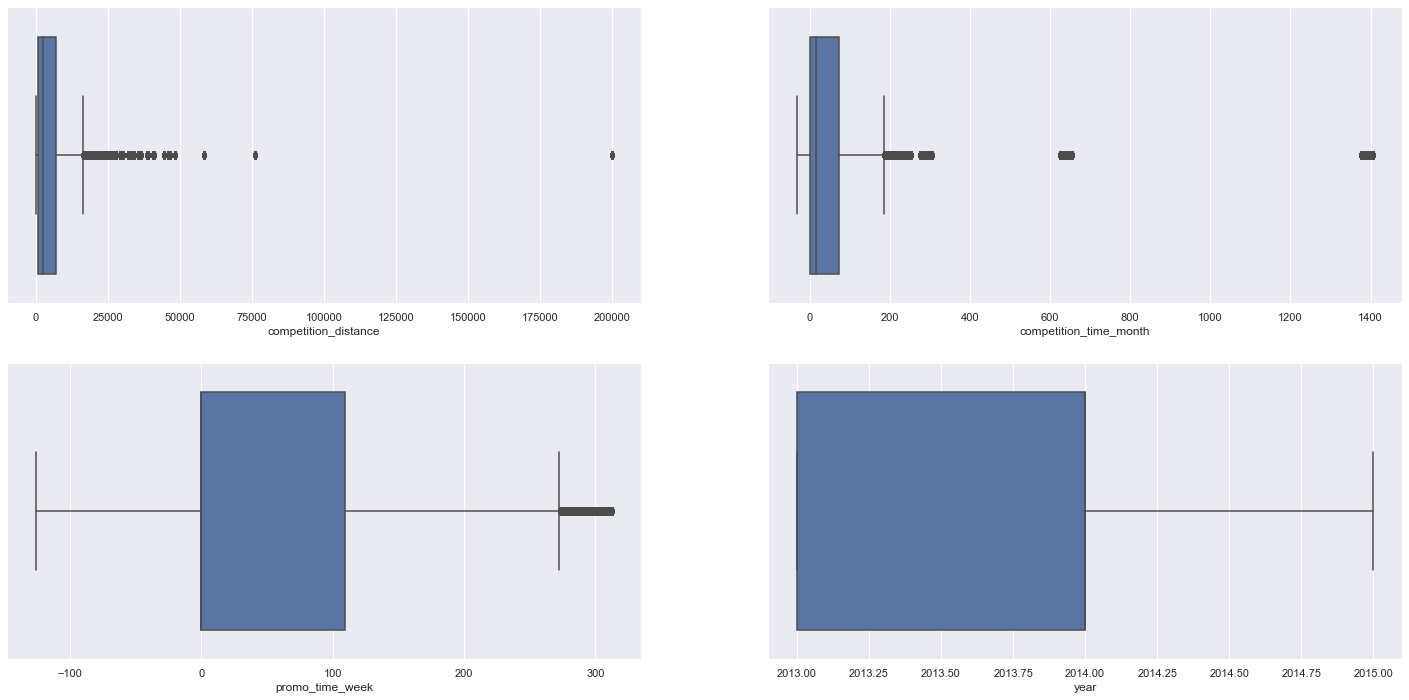

In [125]:
#boxplots
plt.subplot(2,2,1)
sns.boxplot(x = 'competition_distance', data = df5);

plt.subplot(2,2,2)
sns.boxplot(x = 'competition_time_month', data = df5);

plt.subplot(2,2,3)
sns.boxplot(x = 'promo_time_week', data = df5);

plt.subplot(2,2,4)
sns.boxplot(x = 'year', data = df5);

* **competition_distance** \\(\rightarrow\\) There are many outliers, so we will use RobustScaler.
* **year** \\(\rightarrow\\)  There are no outliers, so we will use MinMaxScaler.
* **competition_time_month** \\(\rightarrow\\)  There are many outliers, so we will use RobustScaler.
* **promo_time_week** \\(\rightarrow\\)  There aren't many outliers, so we will use MinMaxScaler.

In [126]:
# instantiate classes
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance - RobustScaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open("scalers/competition_distance_scaler.pkl",'wb'))

#year - MinMaxScaler
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open("scalers/year_scaler.pkl", 'wb'))

#competition_time_month - RobustScaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open("scalers/competition_time_month_scaler.pkl",'wb'))

#promo_time_week - MinMaxScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open("scalers/promo_time_week_scaler.pkl",'wb'))

## 6.3. Transformation<a id='transformation'></a>

* Encoding
* Transformation of the variable response
* Transformation of nature.

### 6.3.1. Encoding


**Label Enconder**

LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1. This is sometimes useful for writing efficient Cython routines. It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.

**One Hot Encoder**

This type of encoding can be obtained with the OneHotEncoder class or the get_dummies function from pandas, which transforms each categorical feature with n_categories possible values into ncategories binary features, with one of them 1, and all others 0. By default, the values each feature can take is inferred automatically from the dataset and can be found in the categories attribute.

**Ordinal Encoder**

To convert categorical features to such integer codes, we can use the OrdinalEncoder. This estimator transforms each categorical feature to one new feature of integers (0 to n_categories - 1) as being ordered.

**Target Encoder**

Gets the mean value of the target variable for each feature class.

**Frequency Encoder**

Similar to the Target Encoder, but instead of getting the mean target value for each feature class, it will be calculated the mean count value.

**Embedding Encoder**

Common in Deep Neural Networks, this encoder attempts to maintain the features distances inside a context. For example, maintaining the words from a specific context neraby from each other. It is widely used in Natural Language Processing (NLP).

In [127]:
#state_holiday - OneHotEncoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

#store_type - LabelEncoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open("scalers/store_type_scaler.pkl",'wb'))

#assortment - OrdinalEncoder
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 6.3.2. Response Variable Transformation

In transforming the response variable, we have to approximate the distribution of the response variable to a normal distribution. This is necessary because machine learning algorithms are built on the basis of assumptions, one of which is that the data is normally distributed. For that to happen, we will use the logarithmic transformation.

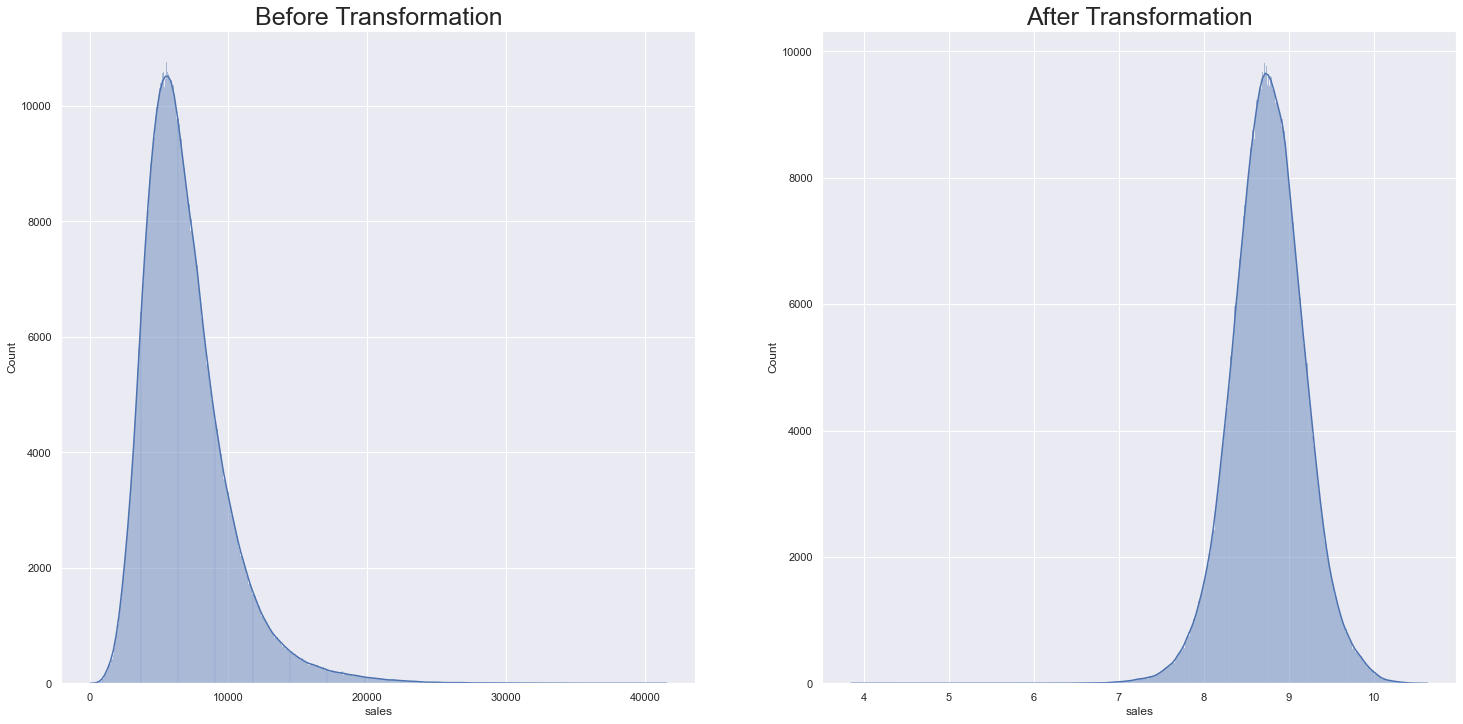

In [128]:
# sales plot before log
plt.subplot(1,2,1)
sns.histplot(x = 'sales', data = df5, kde = True);
plt.title('Before Transformation', fontsize = 25);

# sales plot after log
plt.subplot(1,2,2)
sns.histplot(np.log1p(df5['sales']), kde = True);
plt.title("After Transformation", fontsize = 25);

#logarithmic transformation
df5['sales'] = np.log1p(df5['sales'])

### 6.3.3. Nature Transformation

In nature transformation, we have to bring the true nature of the data to the dataset. In this case, the variable 'month' is cyclical and has to be transformed, as the months are repeated each year that begins. But for that, we don't just list the months 1 to 12 because we lost the sense of cycle due to the different distances.

Therefore, it will be used the trigonometric circle by placing the months as arcs and separating them at equal distances. This process will be done for the variables 'day_of_week', 'month', 'day', 'week_of_year'.

In [129]:
#month 
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2* np.pi/12) ))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2* np.pi/12) ))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2* np.pi/30) ))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2* np.pi/30) ))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2* np.pi/52) ))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2* np.pi/52) ))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2* np.pi/7) ))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2* np.pi/7) ))

# 7. Feature Selection<a id='feature_selection'></a>

Feature Selection is the process where you automatically or manually select those features which contribute most to your prediction variable or output in which you are interested in. Having irrelevant features in your data can decrease the accuracy of the models and make your model learn based on irrelevant features.

In [130]:
df6 = df5.copy()

In [131]:
# drop columns used to contruct other variables
cols_drop = ['month','week_of_year','day','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis = 1)

## 7.1. Split dataframe into training and test dataset<a id='train_test'></a>

The project's objective is to predict sales for the next 6 weeks. Thus, the test data will be the last 6 weeks of the entire dataset and the train data will be the rest.

In [132]:
# getting data to split
df6['date'].max() - datetime.timedelta(days = 7*6)

Timestamp('2015-06-19 00:00:00')

In [133]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print("Training min date: {}".format(X_train['date'].min()))
print("Training max date: {}".format(X_train['date'].max()))

print("\nTest Min date: {}".format(X_test['date'].min()))
print("Test Max Date: {}".format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 7.2. Boruta as Feature Selector<a id='boruta'></a>

The Boruta algorithm is a wrapper built around the random forest classification algorithm. It tries to capture all the important, interesting features you might have in your dataset with respect to an outcome variable.

In [134]:
# # training and test dataset for boruta
# X_train_n = X_train.drop(['date','sales'], axis = 1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs = -1)

# # define boruta
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

### 7.2.1. Best features from boruta

In [135]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date','sales'], axis = 1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)
# cols_selected_boruta

Obtaining the features selected by boruta, we will compare it with our relevance table that was built in the "Exploratory Data Analysis".

## 7.3. Manual Feature Selection<a id='manual_feature_selection'></a>

Although Boruta selects features for the model, it is important to select manually features as well, based on the exploratory data analysis. Here, it will be added the features "month_sin", "week_of_year_sin" and "day_of_week_sin", as they was evaluated as important in the data exploration. 

In [200]:
# columns selected from boruta
cols_selected_boruta = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2','promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_cos',
        'month_sin',
        'day_sin',
        'day_cos',
        'week_of_year_cos',
        'week_of_year_sin'
]

#Full Columns
cols_selected_boruta_full = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin',
                         'date',
                         'sales']

# 8. Machine Learning Modelling<a id='modelling'></a>

It will be used 5 machine learning algorithms to the regression problem:

* Average Model (Baseline Model)
* Linear Regression
* Lasso
* Random Forest Regressor
* XGBoost Regressor

A cross-validation technique will be used to evaluate each algorithm. Using it, results can be better generalized, as the results will be less biased or less optimistic, considering the model will be trained with different samples from the dataset and the remaining samples will be used for testing.

First step for machine learning modelling is to separate predictor variables from target variable and then separate them in training and testing.

In [201]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 8.1. Average Model<a id='average_model'>

In [138]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby("store").mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how = 'left', on = 'store')

yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error("Average Model", np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 8.2. Linear Regression<a id='linear_regression'>

In [139]:
%%time
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

Wall time: 738 ms


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 8.2.1. Linear Regression - Cross Validation

In [140]:
%%time
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

Wall time: 3.37 s


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 8.3. Lasso<a id='lasso'>

In [141]:
%%time
#model
lrr = Lasso(alpha = 0.01).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

Wall time: 735 ms


,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.704881,0.289106,2744.451737


### 8.3.1. Lasso - Cross Validation

In [142]:
%%time
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

Wall time: 3.12 s


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 8.4. Random Forest Regressor<a id='random_forest'>

In [143]:
%%time
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train,y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

Wall time: 3min 22s


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 8.4.1. Random Forest Regressor - Cross Validation

In [144]:
%%time
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
Wall time: 14min 13s


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2


## 8.5. XGBoost Regressor<a id='xgboost'>

In [145]:
%%time
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

Wall time: 5min 11s


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,857.809468,0.125117,1260.20886


### 8.5.1. XGBoost Regressor - Cross Validation

In [146]:
%%time
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
Wall time: 21min 51s


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1038.4 +/- 195.37,0.14 +/- 0.02,1494.1 +/- 273.16


## 8.6. Compare Model's Performance<a id='performance'>

### 8.6.1. Single Performance

In [150]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result ,xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,857.809468,0.125117,1260.208860
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso,1891.704881,0.289106,2744.451737


### 8.6.2. Real Performance - Cross Validation

In [151]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values("RMSE CV")

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2
0,XGBoost Regressor,1038.4 +/- 195.37,0.14 +/- 0.02,1494.1 +/- 273.16
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


It can be seen that the XGBoost Regressor has the best metrics along side the Random Forest Regressor. The XGBoost Regressor will be used as the final model, since its model file is lighter when compared to the Random Forest Regressor one, which can save server space and costs.

# 9. Hyperparameter Fine Tunning<a id='hyperparameter'>

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.
    
Some approaches are:

* GridSearch \\(\rightarrow\\) It is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.

* RandomSearch \\(\rightarrow\\) The Random Search selects randomly a set of hyperparameters among those that were provided and then returns the set that returned the best result.

* Bayesian optimization \\(\rightarrow\\) The algorithm described herein is a type of local random search, where every iteration is dependent on the prior iteration's candidate solution.

## 9.1. RandomizedSearchCV<a id='random_search'>

In [77]:
# defining parameters grid
# param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

# model_xgb = xgb.XGBRegressor()

# xgb_grid_cv = RandomizedSearchCV(model_xgb, param, verbose = True, cv = 2, n_iter = 5, n_jobs = -1, random_state = 42)
# %timeit -n 1 -r 1 xgb_grid_cv.fit(x_train, y_train)

# print(f'Best estimator: {xgb_grid_cv.best_estimator_}')
# print(f'Best score: {xgb_grid_cv.best_score_}')

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[12:43:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1h 33min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best estimator: XGBRegressor(colsample_bytree=0.3, eta=0.01, max_depth=9, min_child_weight=8,
             n_estimators=1500, subsample=0.5)
Best score: 0.7558842670241528


## 9.2. Final Model<a id='final_model'>

In [206]:
# model
model_xgb_tuned = xgb.XGBRegressor(colsample_bytree=0.3, 
                                   eta=0.01, 
                                   max_depth=9, 
                                   min_child_weight=8,
                                   n_estimators=1500, 
                                   subsample=0.5)

model_xgb_tuned.fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

[22:57:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,673.230977,0.098087,971.17674


## 9.3. Exporting Final Model<a id='export_final_model'>

In [207]:
with open('./model/model_rossmann.pickle', 'wb') as file:
    pickle.dump(model_xgb_tuned, file)

# 10. Error Interpretation<a id='error_interpretation'>

Each metric will be explained to better understand business and model performance.

* **MAE**
    * It assigns equal weight to all errors.
    * Robust in the presence of Outliers.
    * Easy understanding by the business team.

* **MAPE**
    * Shows how far the prediction is from the actual value, on average, as a percentage.
    * Widely used to report results.
    * It cannot be used if the response variable contains zero. If you have to predict zero.   

* **RMSE**
    * Big mistakes (outliers) have more weight to this metric.
    * Sensitive in the presence of outliers.
    * Ideal for measuring the performance of the machine learning model.
    
* **MPE**
    * Used to verify if the model is overestimating or subestimating values.
    * Cannot be used to evaluate the model's performance.
    * It cannot be used if the response variable contains zero. If you have to predict zero. 

In [208]:
# transforming back target variables to original scale
df9 = X_test[ cols_selected_boruta_full ].copy()

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 10.1. Business Performance<a id='business_performance'>

Strategies to show results:

* **Comparison to status quo**: compare results to a existing model or the current process.

* **Revenue Increase**: show how much the results represent in terms of capital / revenue increase.

In [209]:
#sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:"MAE"})
df9_aux2 = df9[['store','sales','predictions']].groupby("store").apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0: "MAPE"})

In [210]:
#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')


#scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [211]:
df92.sort_values("MAPE", ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106431.570312,103187.466231,109675.674394,3244.104081,0.540158
908,909,237072.109375,229402.917778,244741.300972,7669.191597,0.525477
875,876,204842.875000,200763.860819,208921.889181,4079.014181,0.317596
840,841,117859.695312,117194.102041,118525.288584,665.593272,0.246496
273,274,193380.984375,191985.844602,194776.124148,1395.139773,0.238248


As observed in the results, we need to report to the business team, that there are stores that are more difficult to make the predictions.

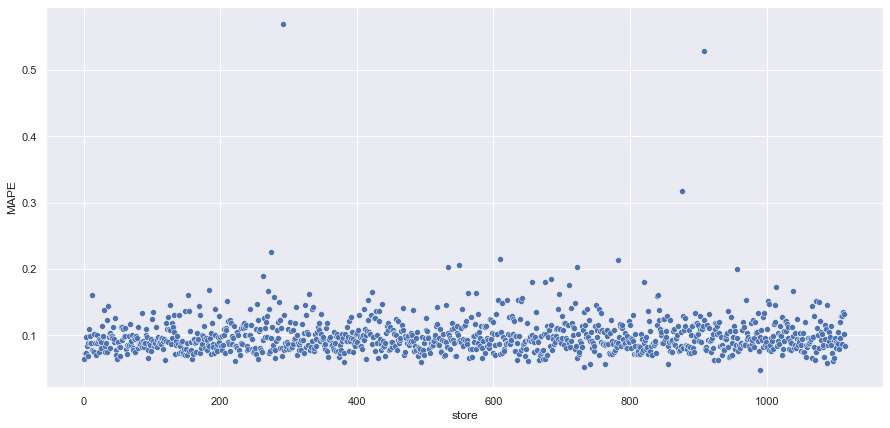

In [190]:
# scatter plot store x MAPE
plt.figure(figsize = (15,7))
sns.scatterplot(x = 'store',y = 'MAPE', data = df92);

There are stores with higher MAPE values, thus being the most challenging ones to predict.

## 10.2. Total Performance<a id='total_performance'>

In [213]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {"index":"Scenario",0:"Values"})

df93['Values'] = df93['Values'].map("R${:,.2f}".format)
df93

,Scenario,Values
0,predictions,"R$285,479,232.00"
1,worst_scenario,"R$284,724,779.16"
2,best_scenario,"R$286,233,663.78"


## 10.3. Machine Learning Performance<a id='machine_learning_performance'>

In [214]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

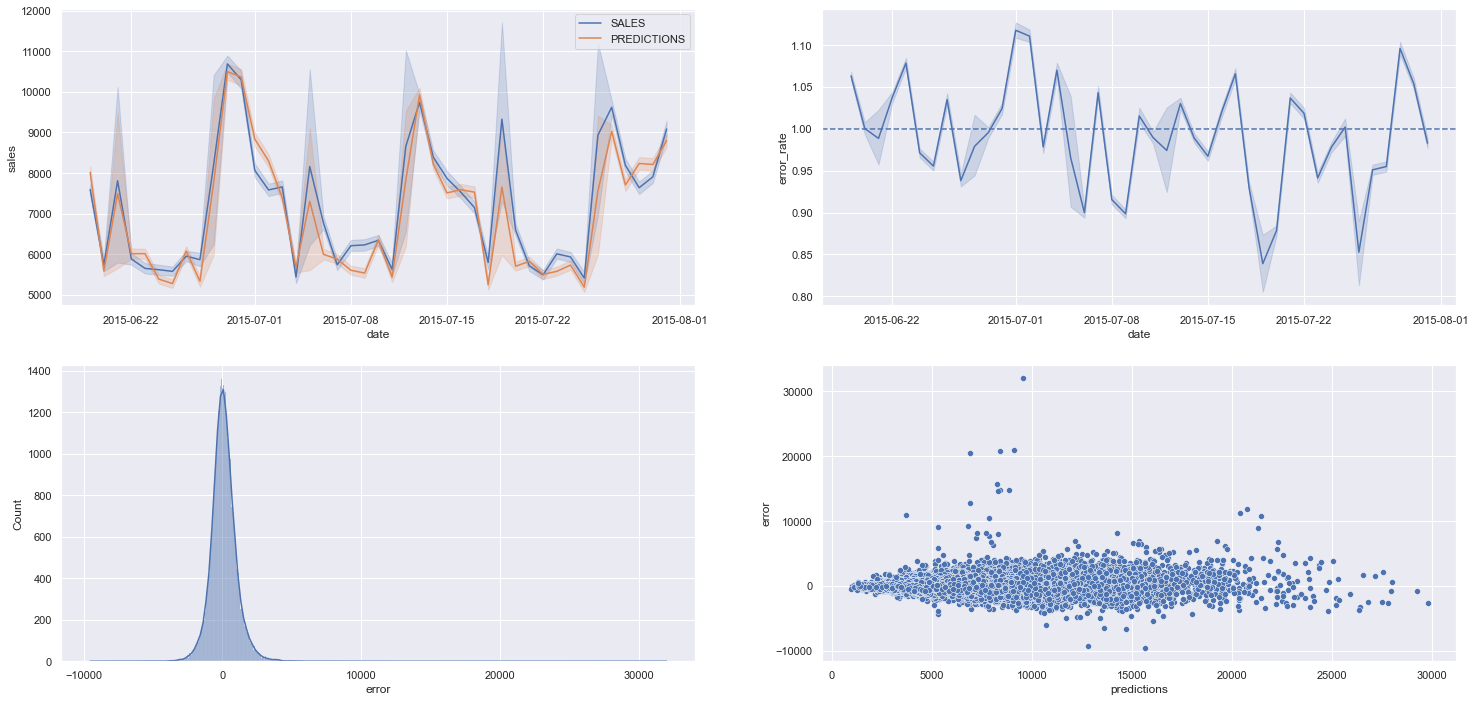

In [215]:
# comparing actual sales with predictions
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

# check error rate by date
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 );
plt.axhline( 1, linestyle='--');

# check error rate in histogram
plt.subplot( 2, 2, 3 )
sns.histplot( x=df9['error'], kde = True);

# check error by predictions
plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] );

* By observing the top left and top right plots, it can be seen that the model's predictions are pretty close to the real values for sales. However, the error rate has some variance. 
* The bottom left plot shows that the residuals distribution follows a normal distribution, which is a premisse of linear regression models that can improve accuracy if adopted.
* The bottom right plot shows the residuals for each predicted value. This contributes to the homoscedasticity study, in which the variance of the residuals should be constant in function of the predicted values. This is another premisse of regression models that improves accuracy if adopted. In the graph, it is possible to see that the residuals has reasonably constant variance, apart from a few outliers.

# 11. Deploy Model to Production<a id='deploy'>

The model developed will be available via API, which will be developed using Flask.

## 11.1. Rossmann Class<a id='rossmann_class'>

In [168]:
class Rossmann( object ):
    def __init__( self ):
        self.home_path=os.path.abspath('')
        with open( os.path.join(self.home_path, 'scalers/competition_distance_scaler.pkl'), 'rb') as file:
            self.competition_distance_scaler = pickle.load( file )
        
        with open( os.path.join(self.home_path, 'scalers/competition_time_month_scaler.pkl'), 'rb') as file:
            self.competition_time_month_scaler = pickle.load( file )
        
        with open( os.path.join(self.home_path, 'scalers/promo_time_week_scaler.pkl'), 'rb') as file:
            self.promo_time_week_scaler = pickle.load( file )
            
        with open( os.path.join(self.home_path, 'scalers/year_scaler.pkl'), 'rb') as file:
            self.year_scaler = pickle.load( file )
        
        with open( os.path.join(self.home_path, 'scalers/store_type_scaler.pkl'), 'rb') as file:
            self.store_type_scaler = pickle.load( file )
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2','promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_cos',
                        'month_sin',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 11.2. API Handler<a id='api_handler'>

In [ ]:
from flask import Flask, request, Response
# from rossmann.Rossmann import Rossmann

# loading model
home_path = os.path.abspath('')

with open(os.path.join(home_path, 'model/model_rossmann.pickle'), 'rb') as file:
    model = pickle.load( file )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 11.3. API Tester<a id='api_tester'>

In [217]:
# loading test dataset
df10 = pd.read_csv( './data/test.csv' )

In [218]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [30, 24, 25] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [219]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [220]:
# API Call
# url = 'http://localhost:5000/rossmann/predict'
url = 'https://rossmann-model-deploy-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [221]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [222]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,9513.870117
1,25,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,c,basic,430.0,4,2003,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2003-04-01T00:00:00.000Z,151,2015-09-14T00:00:00.000Z,0,9976.348633
2,30,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,40.0,2,2014,1,10,2014,"Mar,Jun,Sept,Dec",Sep,0,2015,9,17,38,2015-37,2014-02-01T00:00:00.000Z,19,2014-03-03T00:00:00.000Z,80,5198.225098
3,24,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,9706.670898
4,25,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,c,basic,430.0,4,2003,0,38,2015,0,Sep,0,2015,9,16,38,2015-37,2003-04-01T00:00:00.000Z,151,2015-09-14T00:00:00.000Z,0,9880.358398


In [223]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 24 will sell R$388,759.23 in the next 6 weeks
Store Number 25 will sell R$392,990.23 in the next 6 weeks
Store Number 30 will sell R$193,104.46 in the next 6 weeks
